<table class="table table-bordered">
<tr>
<th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

## Table of Contents<a id="top"></a>
>#### [Step 1: Problem Statement Formulation](#part1)
>#### [Step 2: Exploratory Data Analysis and Data Cleansing](#part2)
>- [2.1 Exploratory Data Analysis](#part2.1)
>>- [2.1.1 Univariate Analysis](#part2.1.1)
>>- [2.1.2 Bivariate Analysis](#part2.1.2)
>- [2.2 Handling Missing Values](#part2.2)
>- [2.3 Determining Cardinality](#part2.3)
>- [2.4 Handling Outliers](#part2.4)
>>- [2.4.1 Handling Outliers in 'price'](#part2.4.1)
>>- [2.4.2 Handling Outliers in 'living_space'](#part2.4.2)
>>- [2.4.3 Handling Outliers in 'floor_level'](#part2.4.3)
>>- [2.4.4 Handling Outliers in 'bedroom_number'](#part2.4.4)
>- [2.5 Handling Rare Categories](#part2.5)
>>- [2.5.1 Dropping Rare Categories](#part2.5.1)
>>- [2.5.2 Regrouping Rare Categories](#part2.5.2)
>#### [Step 3: Data Wrangling & Transformation](#part3)
>- [3.1 Train Test Split](#part3.1)
>- [3.2 Categorical Encoding](#part3.2)
>- [3.3 Numerical Transformation](#part3.3)
>- [3.4 Feature Scaling](#part3.4)
>#### [Step 4: Machine Learning Modelling](#part4)
>- [4.1 Overview of Final Dataset](#part4.1)
>- [4.2 Linear Regression](#part4.2)
>- [4.3 Decision Tree Regressor](#part4.3)
>- [4.4 Random Forest Regressor](#part4.4)
>#### [Step 5: Model Evaluation & Selection](#part5)
>- [5.1 Linear Regression Evaluation](#part5.1)
>- [5.2 Decision Tree Regressor Evaluation](#part5.2)
>- [5.3 Random Forest Regressor Evaluation](#part5.3)
>#### [Step 6: Report](#part6)


Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

In [1]:
# import the packages
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

import numpy as np

from scipy import stats

from pyspark.sql.functions import col,isnan, when, count, mean, avg, collect_list, when, countDistinct, log, sqrt, pow, log1p, udf, format_number

from pyspark.sql.types import DoubleType

from pyspark.ml.stat import Correlation

import matplotlib.pyplot as plt

import seaborn as sns

from pyspark.ml import Pipeline

from pyspark.ml.feature import OneHotEncoder, StringIndexer

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import StandardScaler

from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import RandomForestRegressor

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

## Step 1: Problem Statement Formulation<a id="part1"></a>
[Go to Report](#part6)

In [2]:
# load and explore data
df=spark.read.csv('thailand_ppty_asg1.csv', header=True, inferSchema=True) 

In [3]:
# Display number of rows and columns
print((df.count(), len(df.columns)))

(41360, 18)


In [4]:
df.printSchema()

root
 |-- sub_property_type: string (nullable = true)
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



In [5]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
df

sub_property_type,living_space,bathroom_number,currency,property_type,property_id,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,76.86,2,Baht,Condo,9942777,Dusit,6,Bangkok,2010,13.79101869,0,2,"Samsen Road, Dusi...",NORMAL,100.5162452,Freehold,5500000
For Sale,42.0,1,Baht,Condo,9807686,Dusit,4,Bangkok,2010,13.79101869,0,1,"Samsen Road, Dusi...",NORMAL,100.5162452,Freehold,4100000
For Sale,123.0,2,Baht,Detached House,8934387,Nong Chok,2,Bangkok,2012,13.85948084,0,3,"Mit Maitri Road, ...",CORPORATE,100.8482369,Freehold,1650000
For Sale,180.0,2,Baht,Detached House,9836450,Nong Chok,2,Bangkok,2011,13.859683,0,4,"Soi Mitmaitri 2, ...",NORMAL,100.857774,Freehold,3650000
For Sale,35.35,1,Baht,Condo,9407447,Bang Rak,56,Bangkok,2018,13.73158352,0,1,"- Rama 4 Road, Si...",CORPORATE,100.5311729,Freehold,7850000
For Sale,70.0,2,Baht,Condo,9753414,Bang Rak,3,Bangkok,2013,13.72303261,0,2,98 Sathorn Nua Ro...,NORMAL,100.5255951,Freehold,11500000
For Sale,78.26,2,Baht,Condo,6111715,Bang Rak,25,Bangkok,2016,13.72245682,0,2,"78 Pan Road, Silo...",NORMAL,100.5235408,Freehold,14700000
For Sale,40.0,1,Baht,Condo,8289876,Bang Rak,15,Bangkok,2016,13.719843,1,1,158 Sathorn Nua R...,CORPORATE,100.522067,Freehold,8400000
For Sale,37.0,1,Baht,Condo,9823002,Bang Rak,10,Bangkok,2010,13.72264955,1,1,48 Soi Sathorn 10...,CORPORATE,100.5272987,Freehold,4590000
For Sale,37.47,1,Baht,Condo,10051786,Bang Rak,8,Bangkok,2013,13.725086,1,1,- Soi Pipat 2 Sil...,NORMAL,100.53313,Freehold,5300000


## Step 2: Exploratory Data Analysis and Data Cleansing<a id="part2"></a>
### 2.1 Exploratory Data Analysis<a id="part2.1"></a>
#### 2.1.1 Univariate Analysis<a id="part2.1.1"></a>
[Go to Report](#part6)

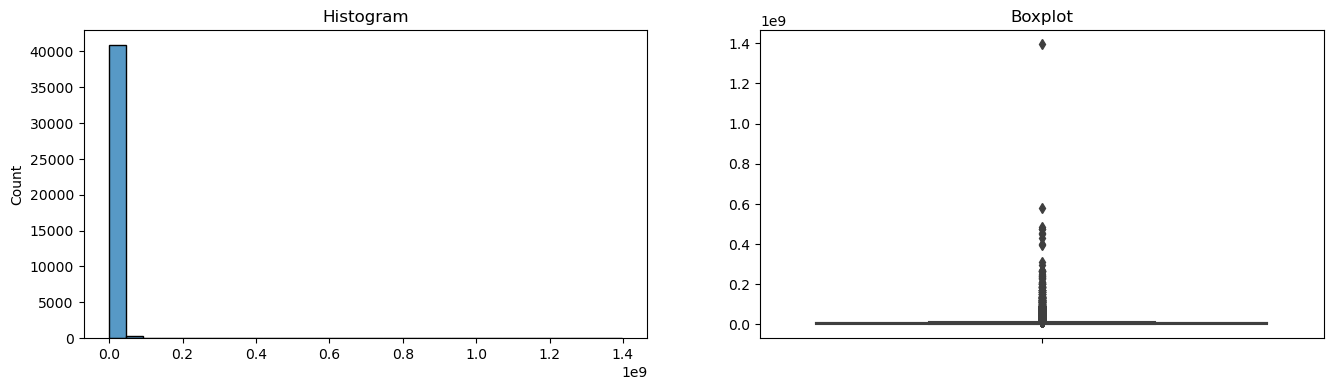

In [6]:
# Univariate Analysis of target -- price
# Collect the column data from PySpark DataFrame
data = df.select('price').rdd.flatMap(lambda x: x).collect()

# define figure size
plt.figure(figsize=(16, 4))

# histogram
plt.subplot(1, 2, 1)
sns.histplot(data, bins=30)
plt.title('Histogram')

# boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=data)
plt.title('Boxplot')

plt.show()

In [7]:
# Split into categorical and numerical variables
cat_cols = ['sub_property_type', 'property_type', 'city', 'state', 'listing_label', 'tenure']
num_cols = ['living_space', 'bathroom_number', 'floor_level', 'built_year', 'latitude', 'premium', 
            'bedroom_number', 'longitude', 'price']

In [8]:
# Univariate analysis of numerical variables (descriptive statistics)
df.select(num_cols).describe()

summary,living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price
count,41310,41360,41360,41360,41360,41360,41360,41360,41360
mean,131.2979258121521,1.2972678916827853,15504.037693423597,2014.3418036750484,13.754093207736465,0.014192456479690523,1.2618471953578336,100.5558954954391,6610496.336532882
stddev,6444.044353131916,0.6902640101287385,3089664.398453431,4.0109587829731295,0.5574710897678714,0.11828511715924905,0.7700069673785545,0.2021853503546363,1.511423482610068E7
min,16.0,0,0,1985,6.028047,0,0,98.280468,0
max,989898.0,9,628266569,2025,19.8936283,1,11,104.717648,1396396324


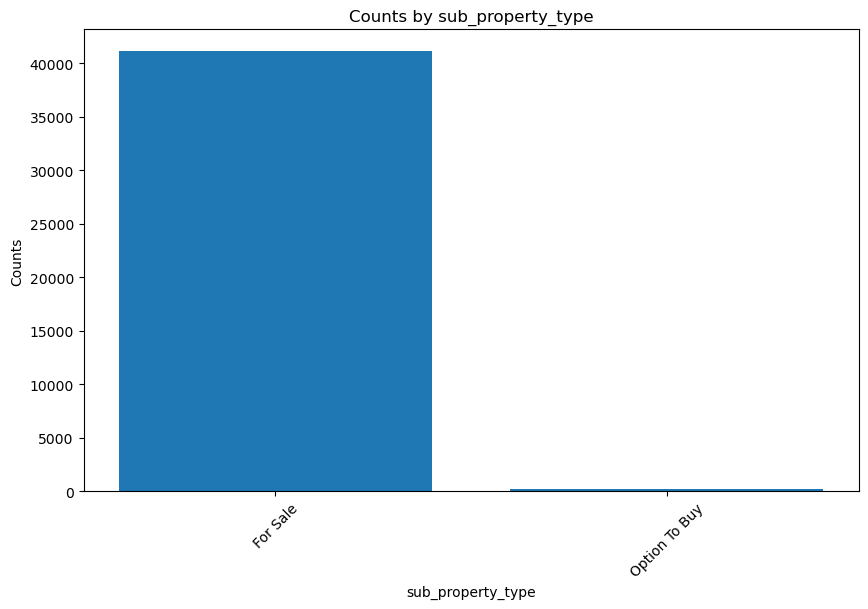

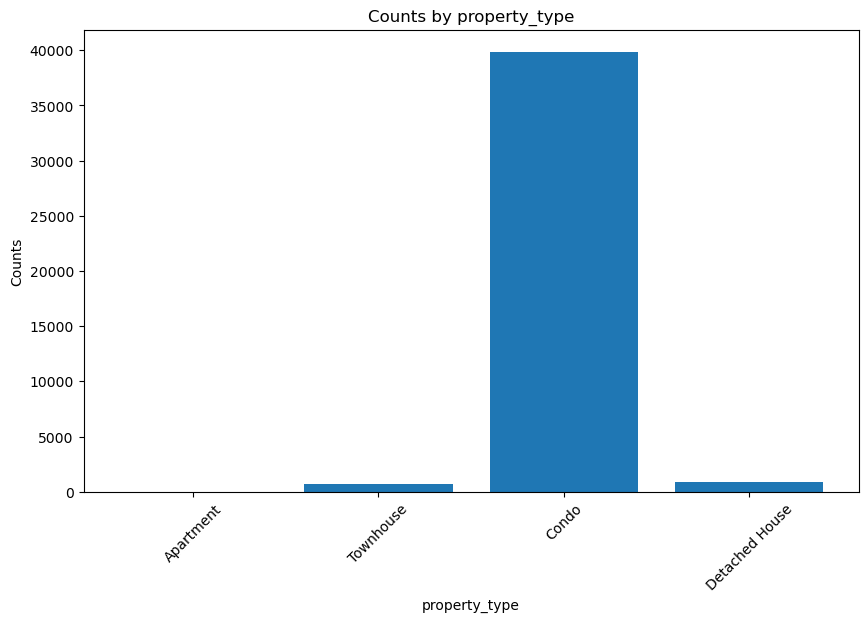

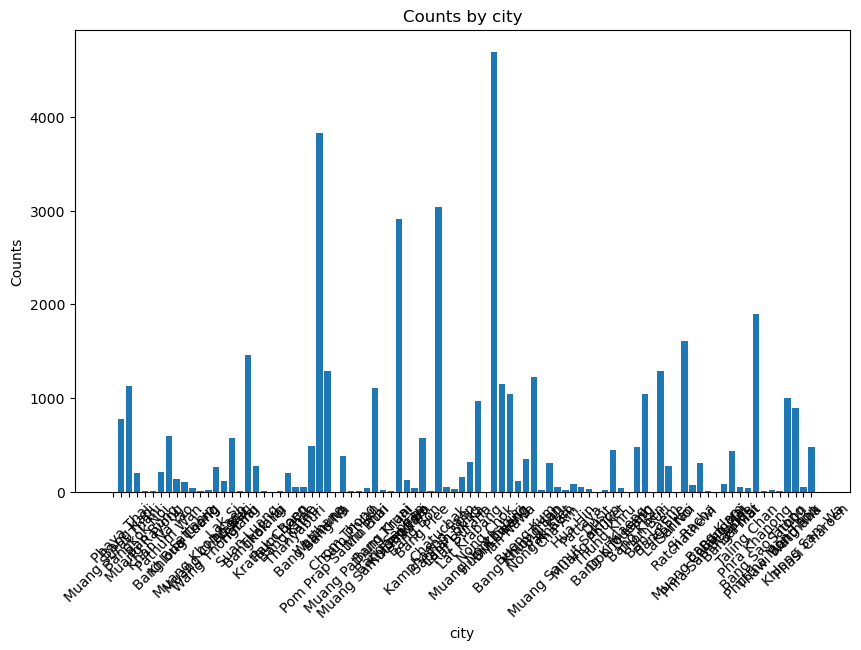

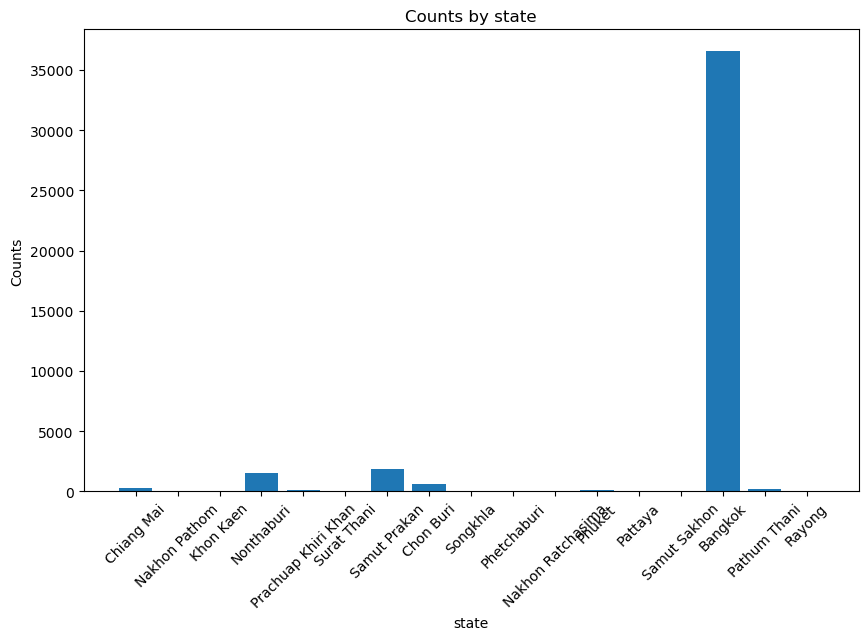

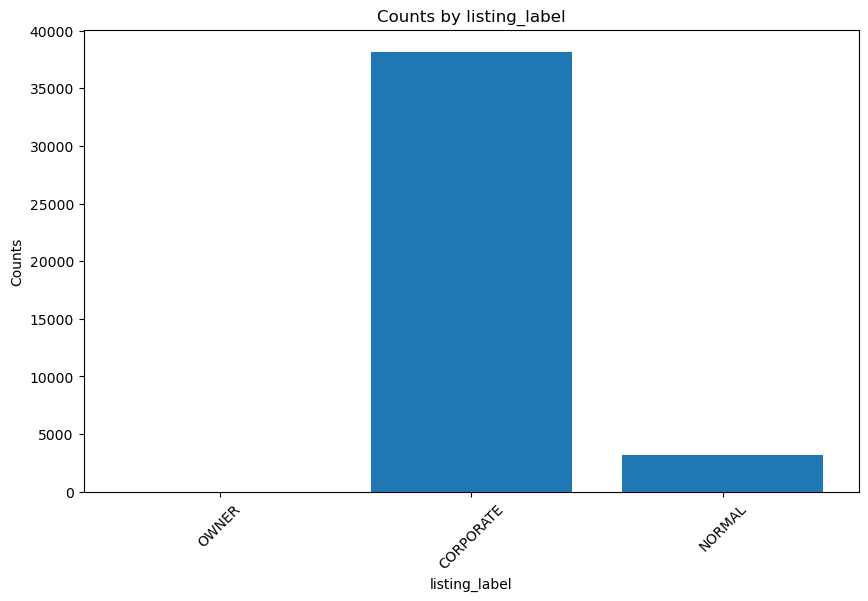

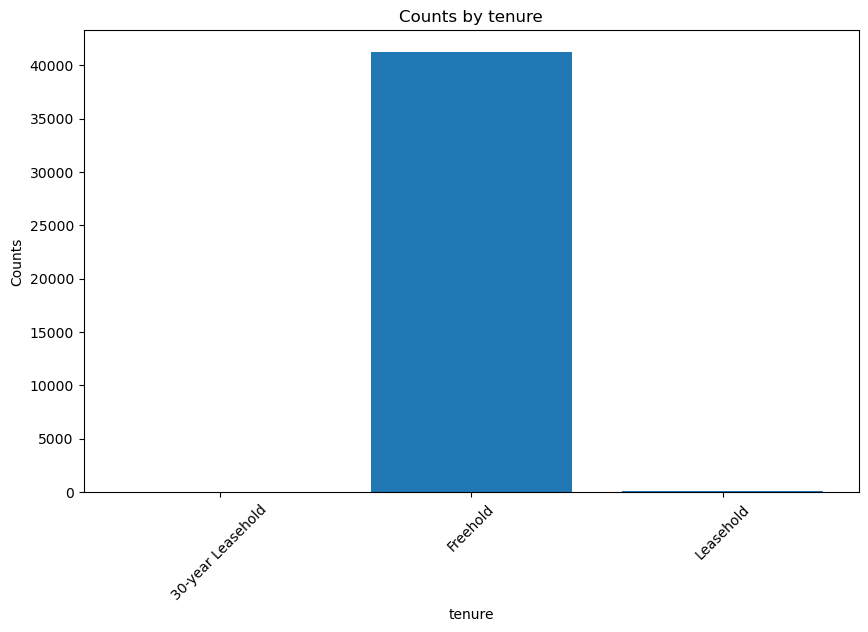

In [9]:
# Univariate analysis of categorical variables
for c in cat_cols:
    # Group by the categorical columns and calculate counts
    grouped_data = df.groupBy(c).count().collect()
    
    # Extracting category names and counts from the collected data
    categories = [row[c] for row in grouped_data]
    cat_counts = [row['count'] for row in grouped_data]
    
    # Plotting using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(categories, cat_counts)
    plt.title(f'Counts by {c}')
    plt.xlabel(c)
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    plt.show()   


#### 2.1.2 Bivariate Analysis<a id="part2.1.2"></a>
[Go to Report](#part6)

In [10]:
# Observe mean price for different categories in a categorical variable
for c in cat_cols:
    # Calculate mean price for each category
    mean_price = df.groupBy(c).agg(mean('price').alias('avg_price'))

    # Display average prices rounded to 2 decimal places
    mean_price.select(c, format_number('avg_price', 2).alias('avg_price')).show()

+-----------------+------------+
|sub_property_type|   avg_price|
+-----------------+------------+
|         For Sale|6,591,872.49|
|    Option To Buy|9,883,677.64|
+-----------------+------------+

+--------------+-------------+
| property_type|    avg_price|
+--------------+-------------+
|     Apartment|43,825,000.00|
|     Townhouse| 6,953,288.17|
|         Condo| 6,387,426.75|
|Detached House|16,816,207.78|
+--------------+-------------+

+-----------------+-------------+
|             city|    avg_price|
+-----------------+-------------+
|Muang Surat Thani| 2,079,000.00|
|       Phaya Thai| 5,841,194.69|
|        Bang Kapi| 2,925,178.00|
|      Bangkok Noi| 3,115,811.88|
|     Muang Rayong| 3,837,600.00|
|         Ban Bung| 2,533,933.33|
|      Khan Na Yao| 3,436,471.42|
|       Pathum Wan|21,471,495.65|
|   Bang Bua Thong| 2,106,597.12|
|     Khlong Luang| 1,581,215.38|
|         Sattahip| 6,737,961.65|
|  Muang Khon Kaen| 2,013,333.33|
|  Muang Chon Buri| 3,342,380.95|
|   Wang

In [11]:
# Observe mean price for different values in a numerical variable
for c in num_cols:
    # Calculate mean price for each category
    mean_price = df.groupBy(c).agg(mean('price').alias('avg_price'))

    # Display average prices rounded to 2 decimal places
    mean_price.select(c, format_number('avg_price', 2).alias('avg_price')).orderBy(c, ascending=True).show()

+------------+------------+
|living_space|   avg_price|
+------------+------------+
|        null|8,592,800.00|
|        16.0|2,023,000.00|
|        20.0|3,985,714.29|
|       20.46|1,803,000.00|
|       20.56|1,100,000.00|
|        21.0|3,027,722.63|
|       21.14|2,600,000.00|
|       21.18|2,690,000.00|
|        21.2|1,490,000.00|
|       21.22|1,400,000.00|
|       21.23|1,250,000.00|
|       21.25|2,275,000.00|
|       21.29|    5,000.00|
|        21.3|2,200,000.00|
|       21.34|3,323,333.33|
|       21.39|2,400,000.00|
|       21.41|2,650,000.00|
|       21.46|2,450,000.00|
|       21.49|2,490,000.00|
|        21.5|1,240,600.00|
+------------+------------+
only showing top 20 rows

+---------------+-------------+
|bathroom_number|    avg_price|
+---------------+-------------+
|              0| 3,251,857.14|
|              1| 3,924,370.12|
|              2|11,514,714.44|
|              3|22,930,253.36|
|              4|34,069,984.01|
|              5|56,847,025.97|
|             

### 2.2 Handling Missing Values<a id="part2.2"></a>
[Go to Report](#part6)

In [12]:
# identifying the number of values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------
 sub_property_type | 0   
 living_space      | 50  
 bathroom_number   | 0   
 currency          | 0   
 property_type     | 0   
 property_id       | 0   
 city              | 0   
 floor_level       | 0   
 state             | 0   
 built_year        | 0   
 latitude          | 0   
 premium           | 0   
 bedroom_number    | 0   
 address           | 0   
 listing_label     | 0   
 longitude         | 0   
 tenure            | 0   
 price             | 0   



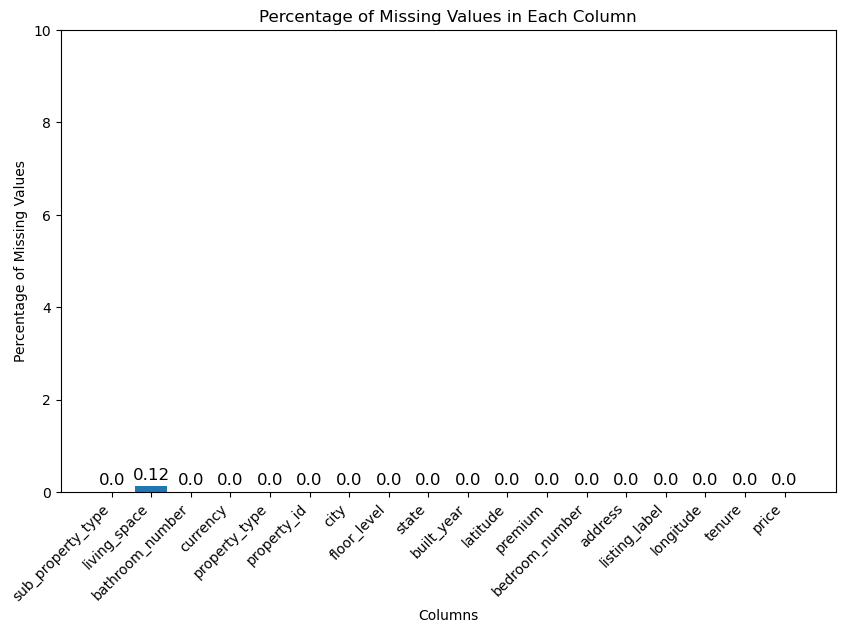

In [13]:
# percentage of null values over the total
total_rows = df.count()
missing_ratios = [(df.filter(col(col_name).isNull()).count() / total_rows)*100 for col_name in df.columns]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(df.columns, missing_ratios)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0,top=10)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')

for x,y in zip(df.columns, missing_ratios):
    label = round(y,2)
    plt.annotate(label, 
                 (x,y), 
                 textcoords = 'offset points', 
                 xytext = (0,5), 
                 ha = 'center',
                fontsize = 12)
    
plt.show()

In [14]:
df.filter(col("living_space").isNull())

sub_property_type,living_space,bathroom_number,currency,property_type,property_id,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,null,1,Baht,Condo,6462781,Khlong Toei,14,Bangkok,2018,13.725635,0,2,68 Sukhumvit 24 A...,CORPORATE,100.566196,Freehold,13000000
For Sale,null,1,Baht,Condo,7132380,Khlong Toei,2,Bangkok,2018,13.725123,0,2,70 Sukhumvit 24 A...,CORPORATE,100.565924,Freehold,12890000
For Sale,null,1,Baht,Condo,9541118,Khlong Toei,2,Bangkok,2017,13.711724,0,2,"Soi Sukhumvit 48,...",CORPORATE,100.594785,Freehold,5500000
For Sale,null,1,Baht,Condo,8811098,Khlong Toei,5,Bangkok,2013,13.71523862,0,2,#NAME?,CORPORATE,100.5905981,Freehold,8500000
For Sale,null,1,Baht,Condo,8807642,Khlong Toei,5,Bangkok,2013,13.71523862,0,2,#NAME?,CORPORATE,100.5905981,Freehold,8500000
For Sale,null,1,Baht,Condo,9699881,Khlong Toei,8,Bangkok,2021,13.735653,0,2,28 Soi Sukhumvit ...,CORPORATE,100.556987,Freehold,12870000
For Sale,null,1,Baht,Condo,9848077,Khlong Toei,17,Bangkok,2018,13.7047129,0,2,"Soi Sukhumvit 50,...",CORPORATE,100.5943438,Freehold,6000000
For Sale,null,1,Baht,Condo,9756624,Khlong Toei,47,Bangkok,2021,13.715821,0,2,"3641 Rama 4 Road,...",CORPORATE,100.575019,Freehold,6065000
For Sale,null,1,Baht,Condo,9604622,Khlong Toei,17,Bangkok,2018,13.7047129,0,2,"Soi Sukhumvit 50,...",CORPORATE,100.5943438,Freehold,6890000
For Sale,null,1,Baht,Condo,9637790,Khlong Toei,47,Bangkok,2020,13.720791,0,2,"Soi Sukhumvit 36,...",CORPORATE,100.57622,Freehold,8480000


In [15]:
# drop rows with null values
df= df.dropna()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------
 sub_property_type | 0   
 living_space      | 0   
 bathroom_number   | 0   
 currency          | 0   
 property_type     | 0   
 property_id       | 0   
 city              | 0   
 floor_level       | 0   
 state             | 0   
 built_year        | 0   
 latitude          | 0   
 premium           | 0   
 bedroom_number    | 0   
 address           | 0   
 listing_label     | 0   
 longitude         | 0   
 tenure            | 0   
 price             | 0   



### 2.3 Determining Cardinality<a id="part2.3"></a>
[Go to Report](#part6)

In [16]:
# Print number of unique values 
for f in df.columns:
    print(str(f) + ': ' + str(df.select(f).distinct().count()))

sub_property_type: 2
living_space: 3028
bathroom_number: 10
currency: 1
property_type: 4
property_id: 41288
city: 89
floor_level: 220
state: 17
built_year: 38
latitude: 1961
premium: 2
bedroom_number: 12
address: 1685
listing_label: 3
longitude: 1956
tenure: 3
price: 3196


In [17]:
# Drop columns with very high cardinality or cardinality of 1
df = df.drop('property_id', 'currency')

### 2.4 Handling Outliers<a id="part2.4"></a>
[Go to Report](#part6)

In [18]:
# Diagnostic plots
def diagnostic_plots(df, variable):
    # Print variable name
    print(f"{variable}:")
    
    # Collect the column data from PySpark DataFrame
    data = df.select(variable).rdd.flatMap(lambda x: x).collect()
    
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data, bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.ylabel('Quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data)
    plt.title('Boxplot')

    plt.show()

In [19]:
# Winsorisation
def winsorize_column(df, column, lower_limit, upper_limit):
    # loop through each col for quantiles
    quantiles = df.approxQuantile(column, [lower_limit, upper_limit], 0.01)
    lower_quantile = quantiles[0]
    upper_quantile = quantiles[1]
    
    # Replace values below the lower percentile with the lower percentile value and 
    # values above the upper percentile with the upper percentile value
    winsorized_df = df.withColumn(column, when(col(column) > upper_quantile, upper_quantile)
                                  .when(col(column) < lower_quantile, lower_quantile).otherwise(col(column)))
    
    return winsorized_df

In [20]:
# Capping
def cap_column(df, column, value):

    # Capping values beyond the value
    capped_df = df.withColumn(column,
                                when(col(column) > value, value)
                                .otherwise(col(column)))

    # return new dataframe
    return capped_df

living_space:


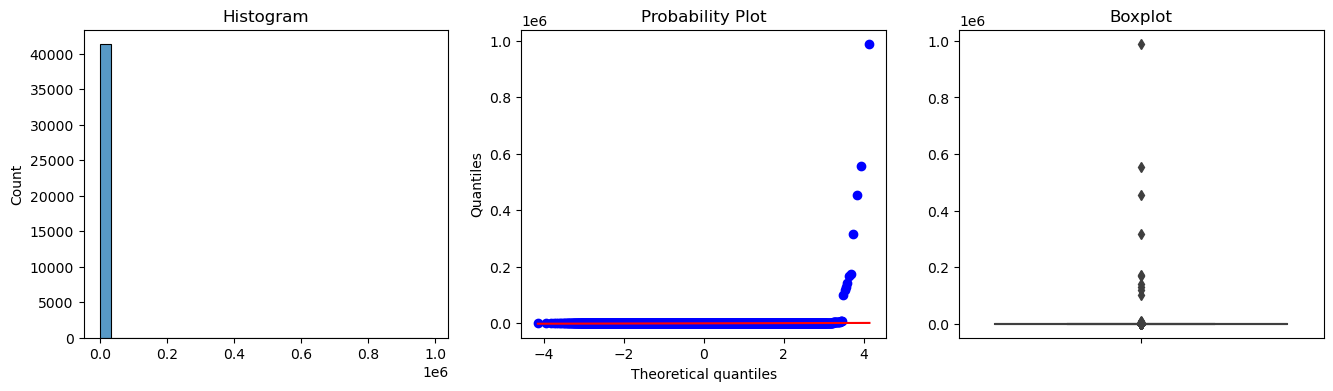

bathroom_number:


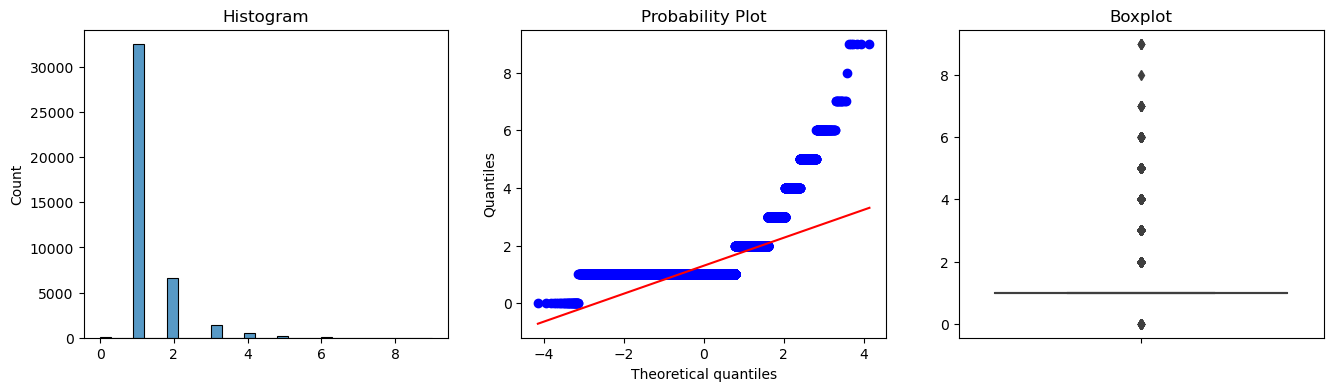

floor_level:


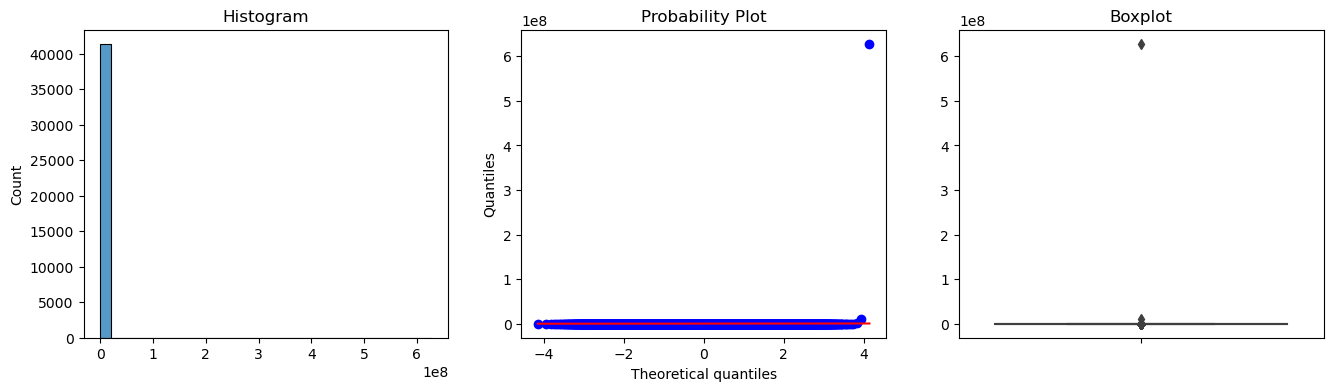

built_year:


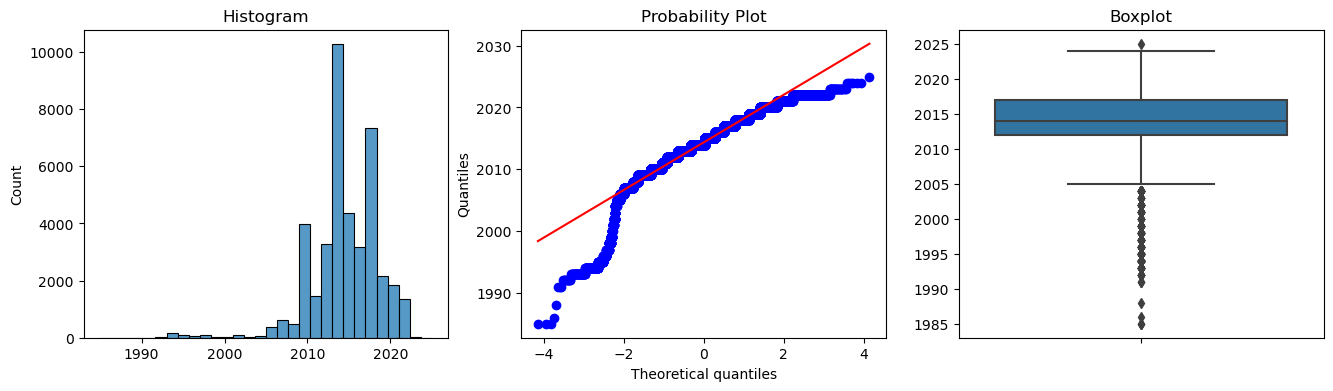

latitude:


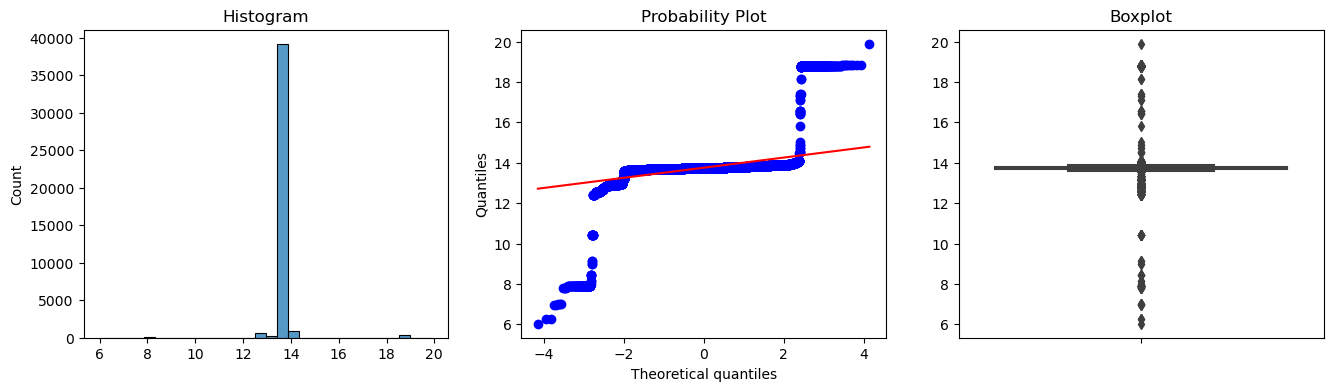

premium:


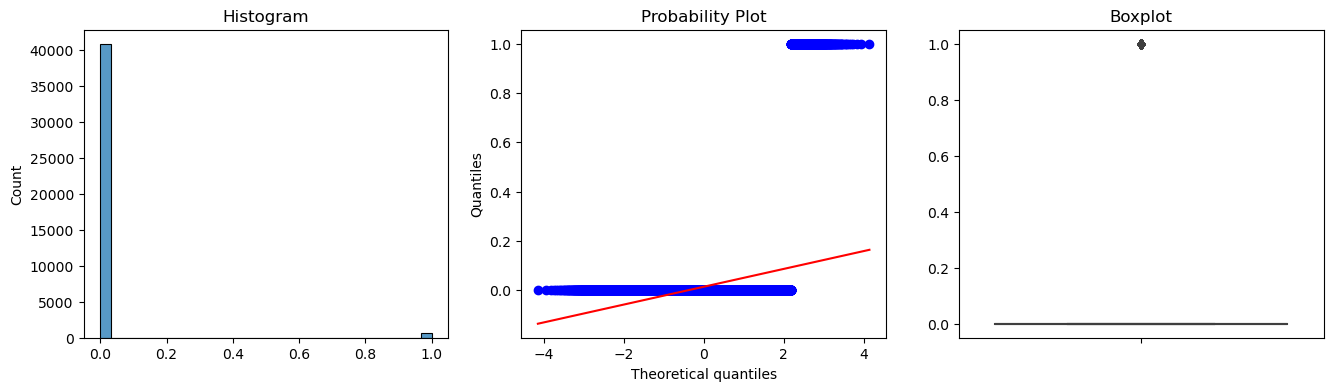

bedroom_number:


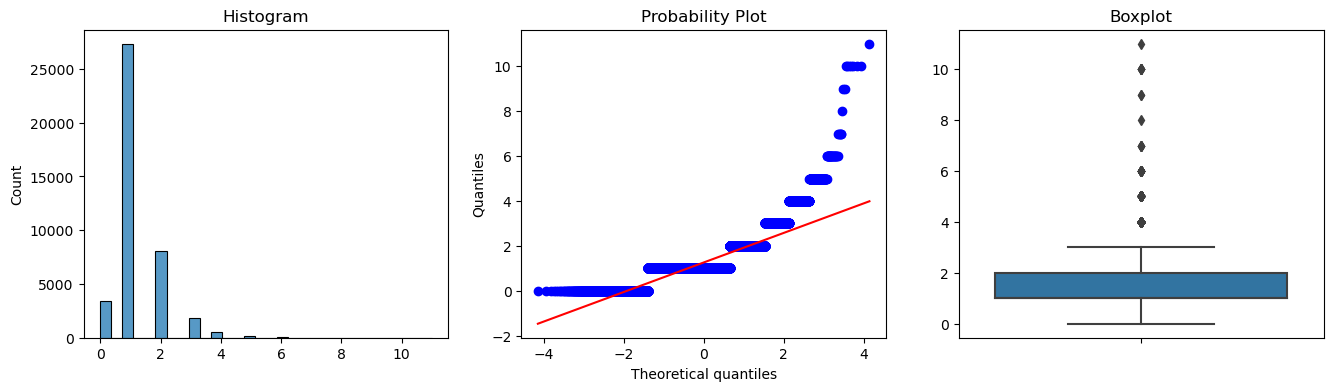

longitude:


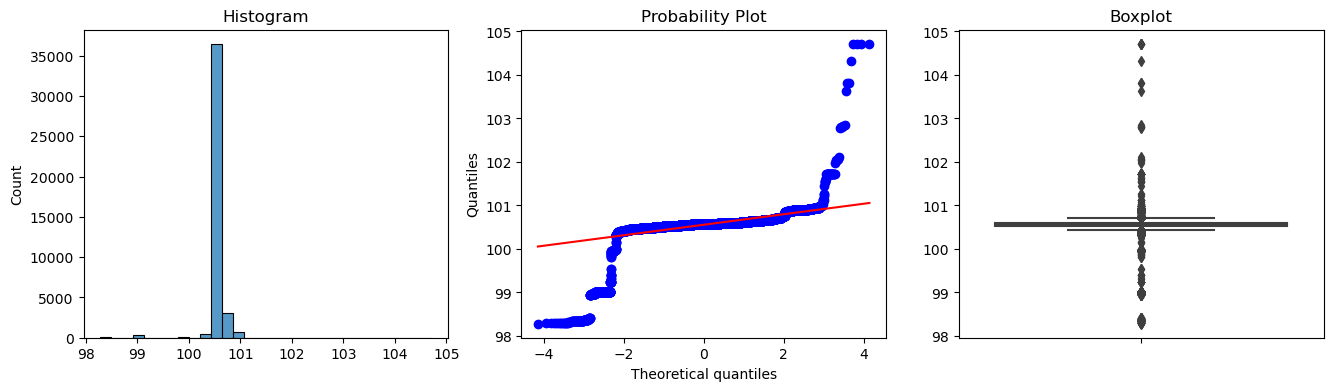

price:


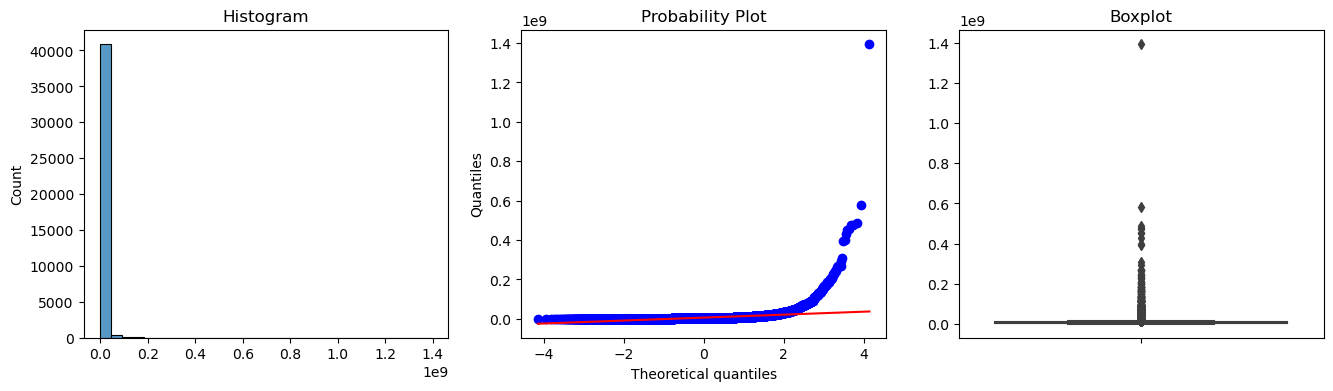

In [21]:
for c in df.columns:
    if c in num_cols:
        diagnostic_plots(df, c)

In [22]:
# Descriptive statistics 
df.select(num_cols).describe()

summary,living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price
count,41310,41310,41310,41310,41310,41310,41310,41310,41310
mean,131.2979258121521,1.2976276930525297,15522.770588235295,2014.3449285887195,13.75413610142533,0.01420963447107238,1.260953764221738,100.55586304253112,6608097.0341079645
stddev,6444.044353131916,0.6906040993063417,3091533.6354612894,4.005812041952957,0.557806933515786,0.11835564986670495,0.7700442066013503,0.2023052009245874,1.5122334862175666E7
min,16.0,0,0,1985,6.028047,0,0,98.280468,0
max,989898.0,9,628266569,2025,19.8936283,1,11,104.717648,1396396324


In [23]:
for n in df.columns:
    if n in num_cols:
        # Calculate the 1st and 3rd quartiles
        quartiles = df.approxQuantile(n, [0.25, 0.75], 0.01)
        
        # Retrieve the 1st (25th percentile) and 3rd (75th percentile) quartiles
        first_quartile = quartiles[0]
        third_quartile = quartiles[1]
        print(f"{n}")
        print(f"1st Quartile (25th percentile): {first_quartile}")
        print(f"3rd Quartile (75th percentile): {third_quartile}\n")
        

living_space
1st Quartile (25th percentile): 29.54
3rd Quartile (75th percentile): 53.0

bathroom_number
1st Quartile (25th percentile): 1.0
3rd Quartile (75th percentile): 1.0

floor_level
1st Quartile (25th percentile): 5.0
3rd Quartile (75th percentile): 25.0

built_year
1st Quartile (25th percentile): 2012.0
3rd Quartile (75th percentile): 2017.0

latitude
1st Quartile (25th percentile): 13.712015
3rd Quartile (75th percentile): 13.77885173

premium
1st Quartile (25th percentile): 0.0
3rd Quartile (75th percentile): 0.0

bedroom_number
1st Quartile (25th percentile): 1.0
3rd Quartile (75th percentile): 2.0

longitude
1st Quartile (25th percentile): 100.533172
3rd Quartile (75th percentile): 100.600417

price
1st Quartile (25th percentile): 2200000.0
3rd Quartile (75th percentile): 6300000.0



#### 2.4.1 Handling Outliers in 'price'<a id="part2.4.1"></a>
[Go to Report](#part6)

In [24]:
# Observe maximum value in price
df.filter(col('price') == df.agg({'price': 'max'}).collect()[0][0])

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,36.53,1,Condo,Prawet,25,Bangkok,2010,13.67279093,0,0,688 Srinakarin Ro...,CORPORATE,100.6452738,Freehold,1396396324


In [25]:
# Observe price in descending order
df.orderBy(col('price').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,36.53,1,Condo,Prawet,25,Bangkok,2010,13.67279093,0,0,688 Srinakarin Ro...,CORPORATE,100.6452738,Freehold,1396396324
For Sale,1180.0,4,Condo,Sathon,1,Bangkok,2012,13.7214254,0,4,3 Sathorn Tai Roa...,CORPORATE,100.5411675,Freehold,580000000
For Sale,709.42,5,Condo,Khlong San,51,Bangkok,2018,13.72812789,0,4,117 Charoen Nakor...,CORPORATE,100.5110346,Freehold,485000000
For Sale,1054.0,6,Condo,Bang Kho Laem,6,Bangkok,2021,13.712088,0,5,64 Charoen Krung ...,CORPORATE,100.510114,Leasehold,475000000
For Sale,1053.0,5,Condo,Bang Kho Laem,73,Bangkok,2021,13.712088,0,5,64 Charoen Krung ...,CORPORATE,100.510114,Leasehold,474192000
For Sale,1008.0,5,Condo,Bang Kho Laem,73,Bangkok,2021,13.712088,0,5,64 Charoen Krung ...,CORPORATE,100.510114,Leasehold,453933000
For Sale,1000.0,6,Condo,Bang Kho Laem,70,Bangkok,2021,13.712088,0,5,64 Charoen Krung ...,CORPORATE,100.510114,Leasehold,450000000
For Sale,605.05,4,Condo,Khlong San,5,Bangkok,2018,13.72812789,0,6,117 Charoen Nakor...,CORPORATE,100.5110346,Freehold,428870000
For Sale,900.0,7,Condo,Bang Kho Laem,56,Bangkok,2017,13.6883,0,7,"888 Rama 3 Road, ...",CORPORATE,100.514401,Freehold,400000000
For Sale,602.0,6,Condo,Khlong San,602,Bangkok,2018,13.72812789,1,5,117 Charoen Nakor...,NORMAL,100.5110346,Freehold,395000000


price:


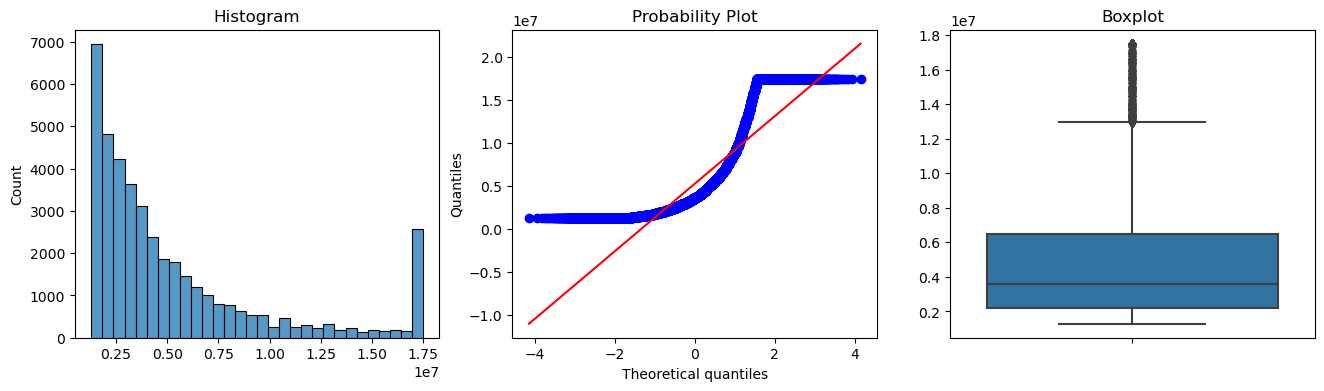

In [26]:
df_w_p = winsorize_column(df, 'price', 0.05, 0.95)
diagnostic_plots(df_w_p,'price')

#### 2.4.2 Handling Outliers in 'living_space'<a id="part2.4.2"></a>
[Go to Report](#part6)

In [27]:
# Observe maximum value in living_space
df_w_p.filter(col('living_space') == df_w_p.agg({'living_space': 'max'}).collect()[0][0])

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,989898.0,2,Condo,Huai Khwang,1,Bangkok,2015,13.760072,0,3,"33/4 Rama 9 Road,...",CORPORATE,100.569425,Freehold,1.2E7


In [28]:
df_w_p.orderBy(col('living_space').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,989898.0,2,Condo,Huai Khwang,1,Bangkok,2015,13.760072,0,3,"33/4 Rama 9 Road,...",CORPORATE,100.569425,Freehold,1.2E7
For Sale,555555.0,1,Condo,Khlong Toei,6,Bangkok,2018,13.725919,0,1,- Soi Sukhumvit 3...,CORPORATE,100.575515,Freehold,1.75E7
For Sale,454545.0,1,Condo,Khlong Toei,37,Bangkok,2013,13.7065231,0,1,"- Sukhumvit 50, S...",CORPORATE,100.599342,Freehold,5500000.0
For Sale,316767.0,2,Condo,Bang Khen,14,Bangkok,2012,13.877401,0,2,104 Chaengwattana...,CORPORATE,100.594094,Freehold,2850000.0
For Sale,173173.0,3,Condo,Khlong San,1,Bangkok,2017,13.7273646,0,3,215 Charoen Nakho...,CORPORATE,100.5105874,Freehold,1.75E7
For Sale,169169.0,3,Detached House,Bang Plee,2,Samut Prakan,2010,13.62828588,0,3,455 Bang Phli - K...,NORMAL,100.7110369,Freehold,5900000.0
For Sale,142142.0,3,Detached House,Bang Plee,2,Samut Prakan,2019,13.584616,0,3,Theparak Km.15 Ro...,CORPORATE,100.733333,Freehold,4690000.0
For Sale,128128.0,2,Condo,Huai Khwang,2,Bangkok,2015,13.760072,0,2,"33/4 Rama 9 Road,...",CORPORATE,100.569425,Freehold,1.75E7
For Sale,119119.0,2,Townhouse,Suan Luang,2,Bangkok,2016,13.72626932,0,2,Soi Phatthanakan ...,NORMAL,100.6341705,Freehold,3610000.0
For Sale,102101.999,2,Condo,Huai Khwang,86,Bangkok,2015,13.760072,0,3,"33/4 Rama 9 Road,...",CORPORATE,100.569425,Freehold,1.3E7


living_space:


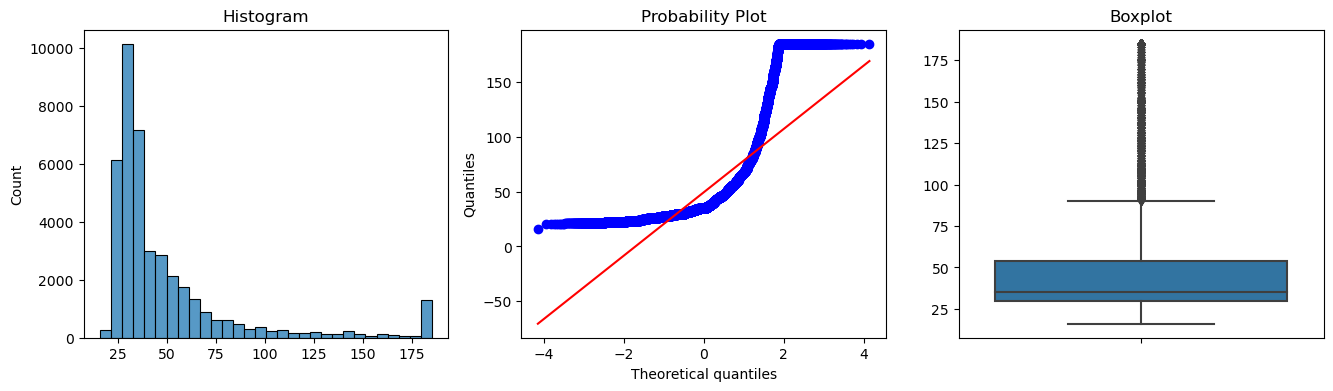

In [29]:
# Winsorise living_space
df_w_ls = winsorize_column(df_w_p, 'living_space', 0.00, 0.98)
diagnostic_plots(df_w_ls,'living_space')

#### 2.4.3 Handling Outliers in 'floor_level'<a id="part2.4.3"></a>
[Go to Report](#part6)

In [30]:
# Observe maximum value in floor_level
df_w_ls.filter(col('floor_level') == df_w_ls.agg({'floor_level': 'max'}).collect()[0][0])

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,31.0,1,Condo,Bang Kho Laem,628266569,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,2940000.0


In [31]:
# Get address of max value in floor_level
df_w_ls.select('address').filter(col('floor_level') == df_w_ls.agg({'floor_level': 'max'}).collect()[0][0]).show(truncate=False)

+---------------------------------------------+
|address                                      |
+---------------------------------------------+
|Rama 3 Road, Bang Klo, Bang Kho Laem, Bangkok|
+---------------------------------------------+



In [32]:
# Observe rows with the address
df_w_ls.filter(df_w_ls['address'] == 'Rama 3 Road, Bang Klo, Bang Kho Laem, Bangkok').orderBy(col('floor_level').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,31.0,1,Condo,Bang Kho Laem,628266569,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,2940000.0
For Sale,53.0,1,Condo,Bang Kho Laem,2565,Bangkok,2022,13.689928,0,2,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,5150000.0
For Sale,30.2,1,Condo,Bang Kho Laem,38,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,3290000.0
Option To Buy,30.0,1,Condo,Bang Kho Laem,36,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,3950000.0
For Sale,30.0,1,Condo,Bang Kho Laem,36,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,3920000.0
Option To Buy,90.0,2,Condo,Bang Kho Laem,34,Bangkok,2022,13.689928,0,3,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,1.22E7
Option To Buy,90.0,2,Condo,Bang Kho Laem,33,Bangkok,2022,13.689928,0,3,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,1.22E7
Option To Buy,112.8,3,Condo,Bang Kho Laem,33,Bangkok,2022,13.689928,0,3,"Rama 3 Road, Bang...",NORMAL,100.50389,Freehold,1.423E7
Option To Buy,91.0,2,Condo,Bang Kho Laem,32,Bangkok,2022,13.689928,0,3,"Rama 3 Road, Bang...",NORMAL,100.50389,Freehold,1.259E7
For Sale,90.0,2,Condo,Bang Kho Laem,32,Bangkok,2022,13.689928,0,3,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,1.24E7


In [33]:
df_w_ls.orderBy(col('floor_level').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,31.0,1,Condo,Bang Kho Laem,628266569,Bangkok,2022,13.689928,0,1,"Rama 3 Road, Bang...",CORPORATE,100.50389,Freehold,2940000.0
For Sale,33.07,1,Condo,Muang Samut Prakarn,10210511,Samut Prakan,2020,13.658262,0,1,ซอยสุขุมวิท 70 ถน...,CORPORATE,100.599962,Freehold,3350000.0
For Sale,27.0,1,Condo,Bangkok Noi,920006,Bangkok,2012,13.785537,0,1,151 Boromarajonan...,CORPORATE,100.469754,Freehold,1900000.0
For Sale,34.0,1,Condo,Khlong Toei,212925,Bangkok,2021,13.715821,0,1,"3641 Rama 4 Road,...",CORPORATE,100.575019,Freehold,4290000.0
For Sale,46.0,1,Condo,Huai Khwang,11813,Bangkok,2022,13.744901,0,2,"Phetchaburi Rd, B...",CORPORATE,100.582269,Freehold,5280000.0
For Sale,46.0,1,Condo,Huai Khwang,11813,Bangkok,2022,13.744901,0,2,"Phetchaburi Rd, B...",CORPORATE,100.582269,Freehold,5280000.0
For Sale,23.0,1,Condo,Bang Bua Thong,11110,Nonthaburi,2016,13.88957,0,1,#NAME?,CORPORATE,100.405623,Freehold,1290000.0
For Sale,42.0,1,Condo,Bang Rak,10500,Bangkok,2016,13.719843,0,1,158 Sathorn Nua R...,CORPORATE,100.522067,Freehold,1.05E7
For Sale,77.0,2,Condo,Bang Kho Laem,10120,Bangkok,2014,13.687996,0,2,495 ถนนพระราม 3 แ...,CORPORATE,100.518236,Freehold,9900000.0
For Sale,77.8,2,Condo,Bang Kho Laem,10120,Bangkok,2014,13.687996,0,2,495 ถนนพระราม 3 แ...,CORPORATE,100.518236,Freehold,9900000.0


floor_level:


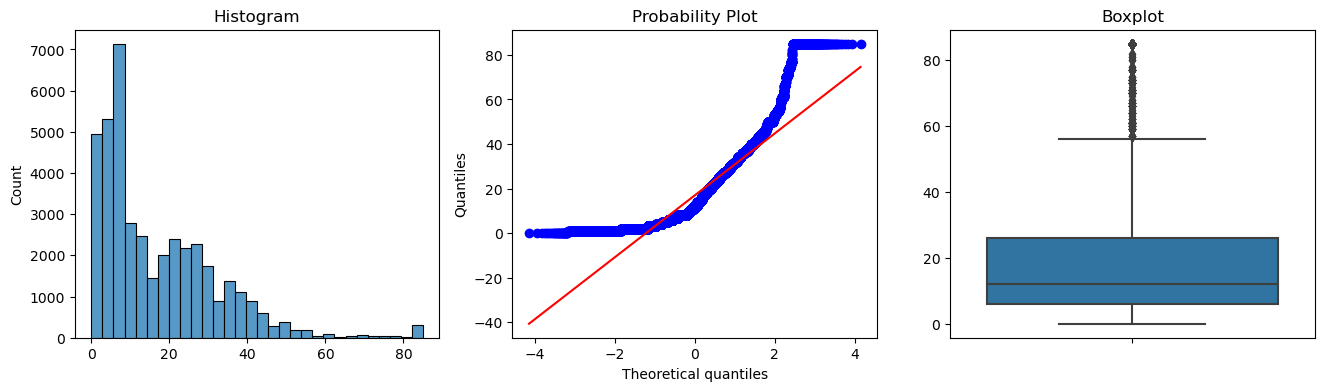

In [34]:
# Cap floor_level
df_c_fl = cap_column(df_w_ls, 'floor_level', 85)
diagnostic_plots(df_c_fl,'floor_level')

#### 2.4.4 Handling Outliers in 'bedroom_number'<a id="part2.4.4"></a>
[Go to Report](#part6)

In [35]:
# Observe maximum value in bedroom_number
df_c_fl.filter(col('bedroom_number') == df_c_fl.agg({'bedroom_number': 'max'}).collect()[0][0])

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,29.0,1,Condo,Bang Lamung,11,Chon Buri,2014,12.930522,0,11,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2800000.0


In [36]:
# Get address of max value in floor_level
df_c_fl.select('address').filter(col('bedroom_number') == df_c_fl.agg({'bedroom_number': 'max'}).collect()[0][0]).show(truncate=False)

+------------------------------------------------+
|address                                         |
+------------------------------------------------+
|88/9 Pattayasaisong Road, Bang Lamung, Chon Buri|
+------------------------------------------------+



In [37]:
# Observe rows with the address
df_c_fl.filter(df_c_fl['address'] == '88/9 Pattayasaisong Road, Bang Lamung, Chon Buri').orderBy(col('bedroom_number').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,29.0,1,Condo,Bang Lamung,11,Chon Buri,2014,12.930522,0,11,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2800000.0
For Sale,51.0,1,Condo,Bang Lamung,32,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,5200000.0
For Sale,51.0,1,Condo,Bang Lamung,15,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,5900000.0
For Sale,70.0,2,Condo,Bang Lamung,30,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,8900000.0
For Sale,70.0,2,Condo,Bang Lamung,30,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,8900000.0
For Sale,50.5,1,Condo,Bang Lamung,24,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,6500000.0
For Sale,30.0,1,Condo,Bang Lamung,11,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2700000.0
For Sale,29.0,1,Condo,Bang Lamung,32,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2990000.0
For Sale,30.0,1,Condo,Bang Lamung,20,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,4190000.0
For Sale,35.0,1,Condo,Bang Lamung,21,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,3500000.0


In [38]:
df_c_fl.orderBy(col('bedroom_number').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,29.0,1,Condo,Bang Lamung,11,Chon Buri,2014,12.930522,0,11,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2800000.0
For Sale,185.0,9,Apartment,Bueng Kum,5,Bangkok,2019,13.776403,0,10,. ถนนเสรีไทย แขวง...,CORPORATE,100.661409,Freehold,1.75E7
For Sale,185.0,9,Apartment,Lat Phrao,4,Bangkok,2012,13.812971,0,10,"Soi Nakniwas 45, ...",CORPORATE,100.610308,Freehold,1.75E7
For Sale,185.0,9,Townhouse,Yan Nawa,5,Bangkok,2016,13.686206,0,10,"Yan Nawa Road, Ch...",CORPORATE,100.537212,Freehold,1.75E7
For Sale,185.0,9,Apartment,Suan Luang,5,Bangkok,2018,13.743283,0,10,#NAME?,CORPORATE,100.603216,Freehold,1.75E7
For Sale,67.0,2,Condo,Huai Khwang,26,Bangkok,2012,13.744204,0,10,#NAME?,CORPORATE,100.585341,Freehold,6500000.0
For Sale,60.0,2,Condo,Watthana,7,Bangkok,2011,13.70622533,0,10,2077 Sukhumvit Ro...,CORPORATE,100.6012631,Freehold,7600000.0
For Sale,185.0,9,Condo,Huai Khwang,4,Bangkok,2011,13.778395,0,10,62 Pracharajbumpe...,NORMAL,100.574172,Freehold,1.3E7
For Sale,185.0,6,Detached House,Bang Plee,3,Samut Prakan,2003,13.64217225,0,9,"Srinakarin Road, ...",NORMAL,100.6357796,Freehold,1.75E7
For Sale,183.0,9,Detached House,Sam Phran,2,Nakhon Pathom,2019,13.71940167,0,9,Phutthamonthon Sa...,CORPORATE,100.3299757,Freehold,1.75E7


In [39]:
# Replace bedroom_number 11 with 1
df_r_bn = df_c_fl.withColumn('bedroom_number',when(col('bedroom_number') == 11, 1).otherwise(col('bedroom_number')))
df_r_bn.filter(df_r_bn['address'] == '88/9 Pattayasaisong Road, Bang Lamung, Chon Buri').orderBy(col('bedroom_number').desc())

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price
For Sale,50.5,1,Condo,Bang Lamung,24,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,6500000.0
For Sale,70.0,2,Condo,Bang Lamung,30,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,8900000.0
For Sale,51.0,1,Condo,Bang Lamung,32,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,5200000.0
For Sale,70.0,2,Condo,Bang Lamung,30,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,8900000.0
For Sale,51.0,1,Condo,Bang Lamung,15,Chon Buri,2014,12.930522,0,2,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,5900000.0
For Sale,30.0,1,Condo,Bang Lamung,11,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2700000.0
For Sale,35.0,1,Condo,Bang Lamung,21,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,3500000.0
For Sale,29.0,1,Condo,Bang Lamung,32,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2990000.0
For Sale,35.0,1,Condo,Bang Lamung,20,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,4600000.0
For Sale,30.0,1,Condo,Bang Lamung,5,Chon Buri,2014,12.930522,0,1,88/9 Pattayasaiso...,CORPORATE,100.883643,Freehold,2950000.0


### 2.5 Handling Rare Categories<a id="part2.5"></a>
[Go to Report](#part6)

In [40]:
# Plot bar chart to identify rare categories & display unique values
def rare_cat(df, variable):
    
    # Group by the variable and count occurrences
    label_freq = df.groupBy(variable).count()
    label_freq.show()
    
    # Get total count of items
    total_item = df.count()

    # Calculate percentage of each category
    label_freq = label_freq.withColumn('percentage', label_freq['count'] / total_item)

    # Collect the calculations into a list
    label_freq_collected = label_freq.collect()

    # Sort by percentage in descending order
    label_freq_collected.sort(key=lambda x: x['percentage'], reverse=True)

    # Extracting data for plotting
    categories = [row[variable] for row in label_freq_collected]
    percentages = [row['percentage'] for row in label_freq_collected]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(categories, percentages)
    plt.axhline(y=0.005, color='red')  # Adding a threshold line

    plt.ylabel('Percentage of items within each category')
    plt.xlabel(f'{variable}')
    plt.title('Identifying Rare Categories')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

+-----------------+-----+
|sub_property_type|count|
+-----------------+-----+
|         For Sale|41076|
|    Option To Buy|  234|
+-----------------+-----+



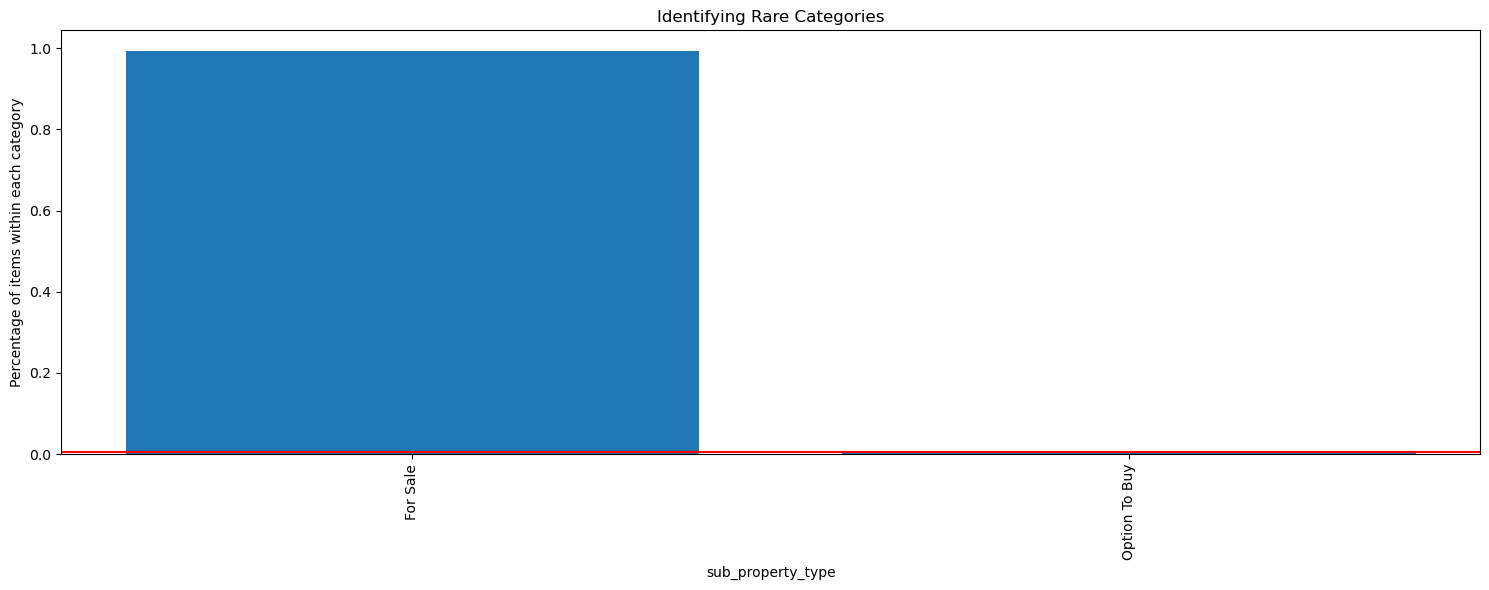

+--------------+-----+
| property_type|count|
+--------------+-----+
|     Apartment|    4|
|     Townhouse|  651|
|         Condo|39820|
|Detached House|  835|
+--------------+-----+



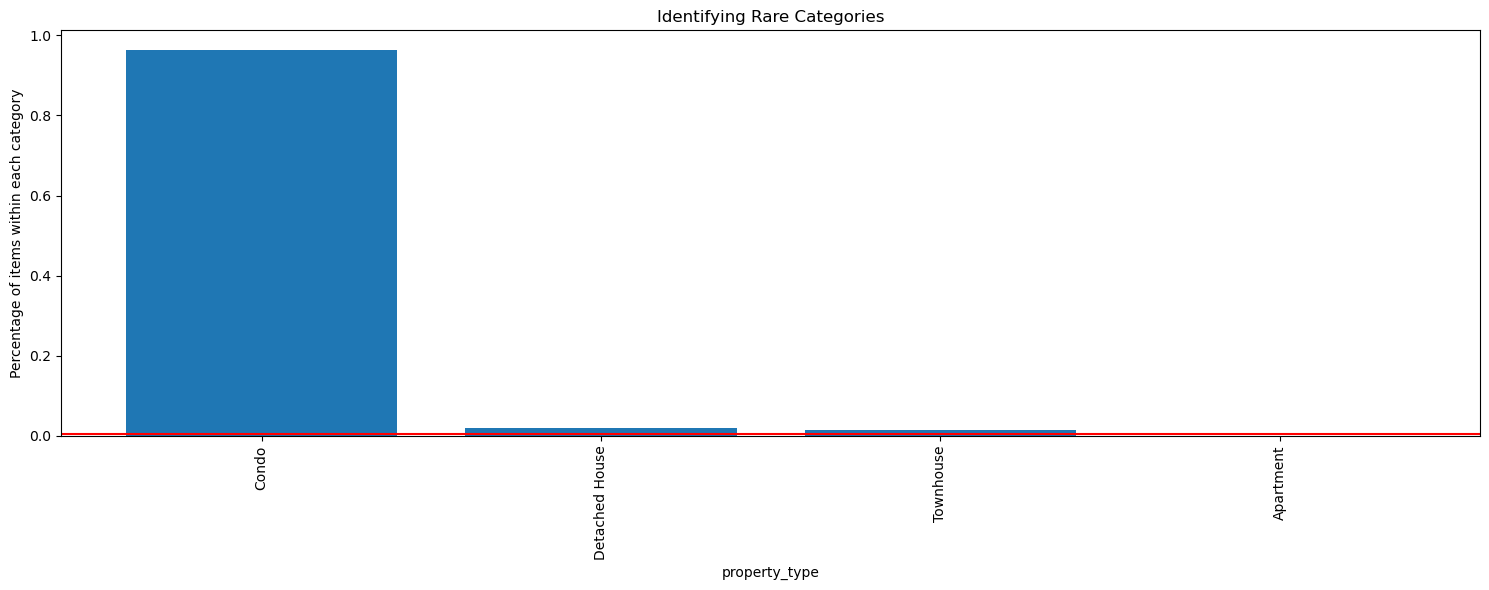

+-----------------+-----+
|             city|count|
+-----------------+-----+
|Muang Surat Thani|    1|
|       Phaya Thai|  772|
|        Bang Kapi| 1132|
|      Bangkok Noi|  202|
|     Muang Rayong|    5|
|         Ban Bung|    6|
|      Khan Na Yao|  210|
|       Pathum Wan|  594|
|   Bang Bua Thong|  139|
|     Khlong Luang|  104|
|         Sattahip|   40|
|  Muang Khon Kaen|    3|
|  Muang Chon Buri|   21|
|   Wang Thonglang|  268|
|           Lak Si|  119|
|           Prawet|  573|
|          Hat Yai|    3|
|       Suan Luang| 1464|
|      Bangkok Yai|  277|
|          Thalang|    4|
+-----------------+-----+
only showing top 20 rows



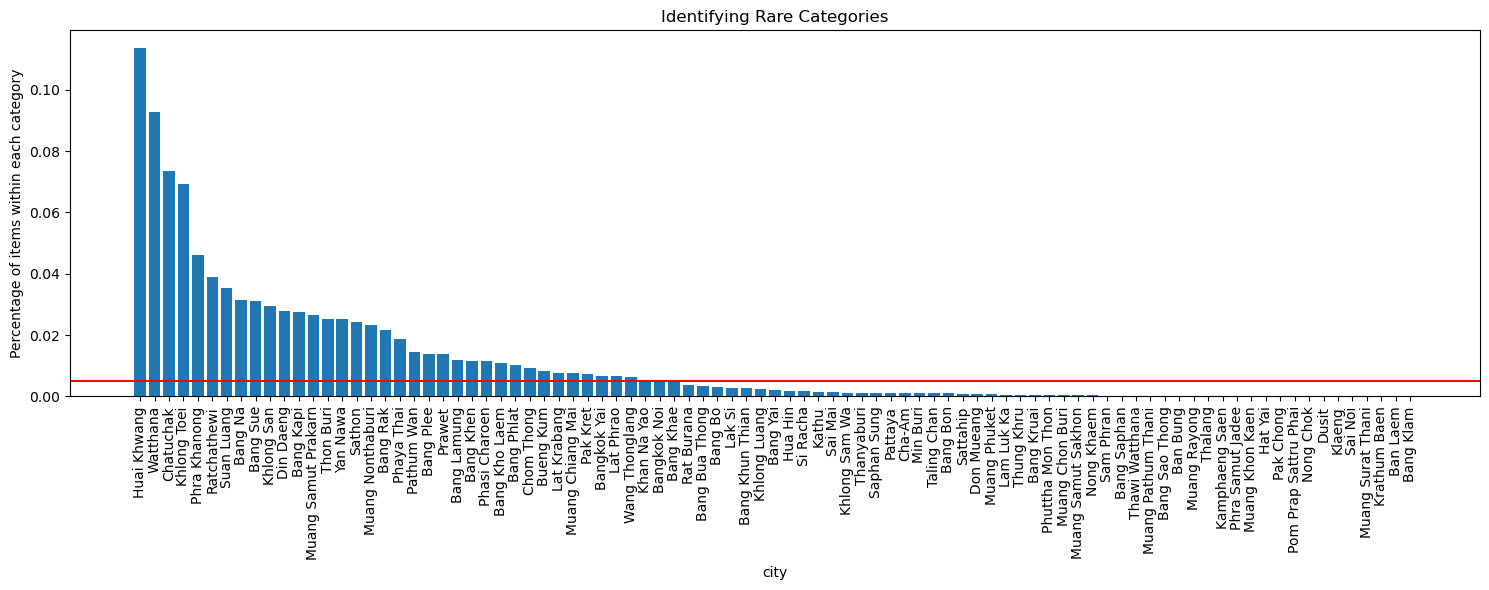

+-------------------+-----+
|              state|count|
+-------------------+-----+
|         Chiang Mai|  310|
|      Nakhon Pathom|   38|
|          Khon Kaen|    3|
|         Nonthaburi| 1516|
|Prachuap Khiri Khan|   90|
|        Surat Thani|    1|
|       Samut Prakan| 1819|
|          Chon Buri|  629|
|           Songkhla|    4|
|        Phetchaburi|   48|
|  Nakhon Ratchasima|    3|
|             Phuket|   88|
|            Pattaya|   49|
|       Samut Sakhon|   21|
|            Bangkok|36494|
|       Pathum Thani|  190|
|             Rayong|    7|
+-------------------+-----+



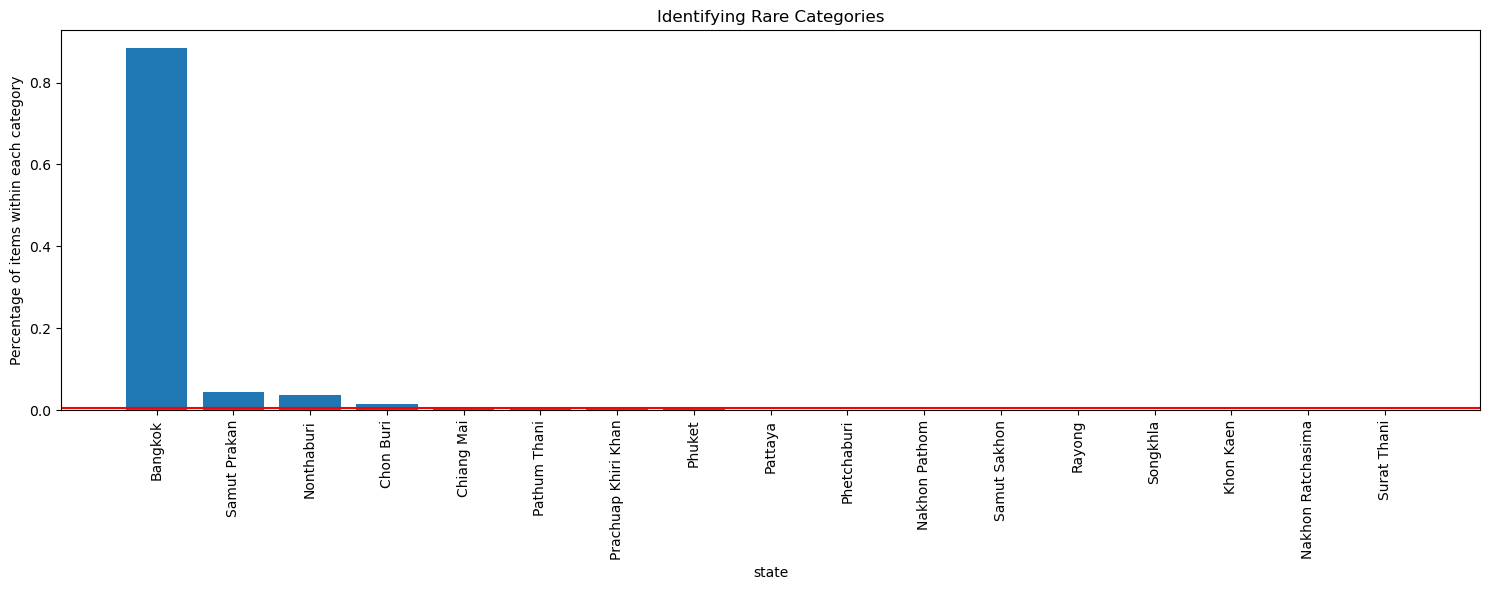

+-------------+-----+
|listing_label|count|
+-------------+-----+
|        OWNER|   18|
|    CORPORATE|38123|
|       NORMAL| 3169|
+-------------+-----+



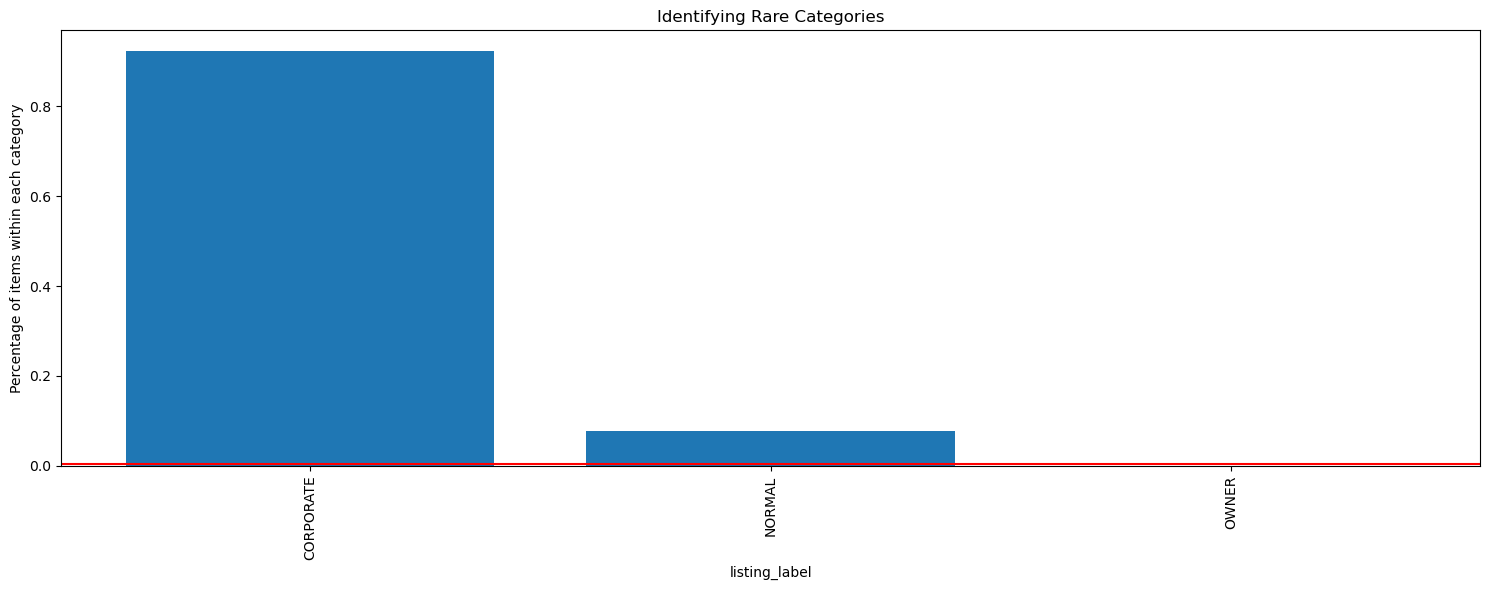

+-----------------+-----+
|           tenure|count|
+-----------------+-----+
|30-year Leasehold|    7|
|         Freehold|41168|
|        Leasehold|  135|
+-----------------+-----+



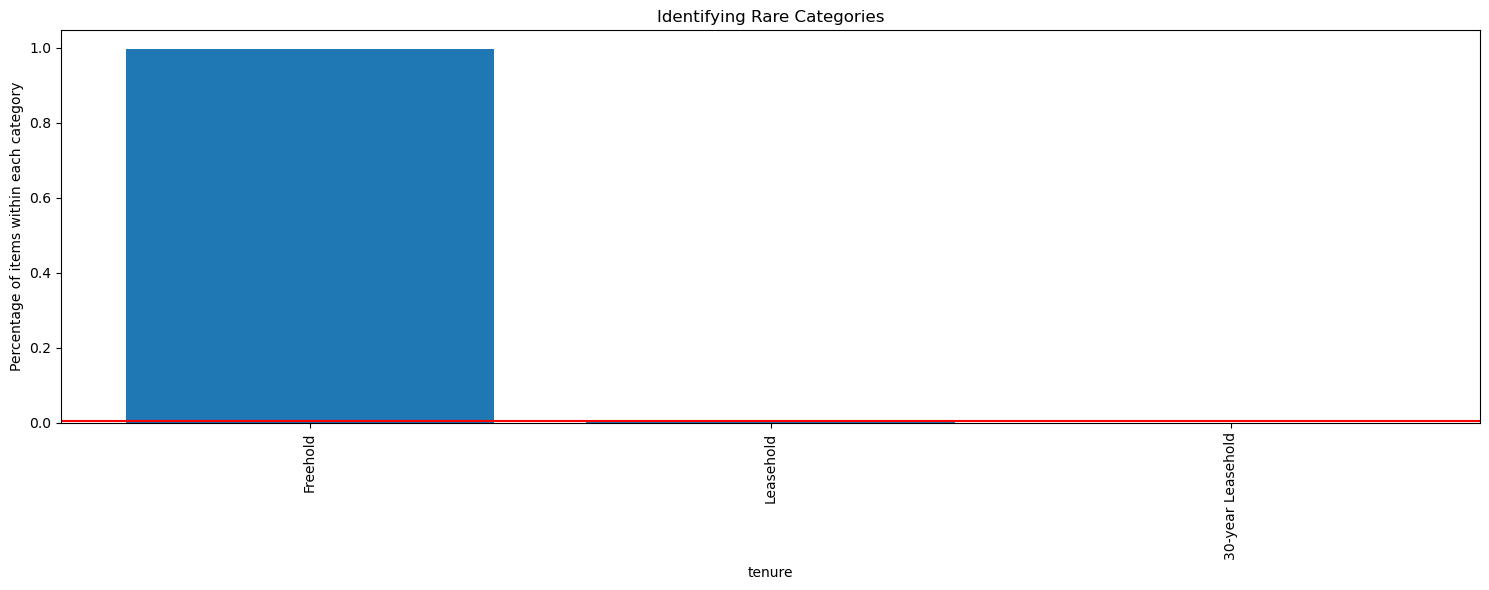

In [41]:
# Observe rare categories
for c in df_r_bn.columns:
    if c in cat_cols:
        rare_cat(df_r_bn, c)

#### 2.5.1 Dropping Rare Categories<a id="part2.5.1"></a>
[Go to Report](#part6)

In [42]:
# Drop apartment in property_type
df_d_a = df_r_bn.filter(~col('property_type').isin('Apartment'))

# Check categories in property_type
df_d_a.groupBy('property_type').count().show()

+--------------+-----+
| property_type|count|
+--------------+-----+
|     Townhouse|  651|
|         Condo|39820|
|Detached House|  835|
+--------------+-----+



In [43]:
# Drop 30-year Leasehold in tenure
df_d_t = df_d_a.filter(~col('tenure').isin('30-year Leasehold'))

# Check categories in property_type
df_d_t.groupBy('tenure').count().show()

+---------+-----+
|   tenure|count|
+---------+-----+
| Freehold|41164|
|Leasehold|  135|
+---------+-----+



#### 2.5.2 Regrouping Rare Categories<a id="part2.5.2"></a>
[Go to Report](#part6)

In [44]:
# Regroup categories not in top 10 in state
# Calculate label frequencies
label_freq = df_d_t.groupBy('state').count()
label_freq = label_freq.withColumn('percentage', col('count') / df_d_t.count())

# Get the top N categories
top_categories = label_freq.orderBy(col('percentage').desc()).limit(10).select('state')
top_categories_list = [row['state'] for row in top_categories.collect()]

# Replace categories not in top 10 with 'other' in the DataFrame
df_top = df_d_t.withColumn('state', when(~col('state').isin(top_categories_list), 'Other').otherwise(col('state')))

# Check categories in state
df_top.groupBy('state').count().show()

+-------------------+-----+
|              state|count|
+-------------------+-----+
|         Chiang Mai|  310|
|         Nonthaburi| 1516|
|Prachuap Khiri Khan|   90|
|              Other|   77|
|       Samut Prakan| 1819|
|          Chon Buri|  629|
|        Phetchaburi|   48|
|             Phuket|   88|
|            Pattaya|   49|
|            Bangkok|36483|
|       Pathum Thani|  190|
+-------------------+-----+



In [45]:
# Regroup rare categories below 0.5% frequency level
# Calculate label frequencies
label_freq = df_top.groupBy('city').count()
label_freq = label_freq.withColumn('percentage', col('count') / df_top.count())

# Get the categories below the threshold
rare_categories = label_freq.filter(col('percentage') < 0.005).select('city')
rare_categories_list = [row['city'] for row in rare_categories.collect()]

# Replace rare categories with 'other' in the DataFrame
df_r_c = df_top.withColumn('city', when(col('city').isin(rare_categories_list), 'Other').otherwise(col('city')))

# Check categories in city
df_r_c.groupBy('city').count().show()

+-------------------+-----+
|               city|count|
+-------------------+-----+
|         Phaya Thai|  772|
|          Bang Kapi| 1132|
|        Khan Na Yao|  210|
|         Pathum Wan|  587|
|     Wang Thonglang|  268|
|             Prawet|  573|
|         Suan Luang| 1463|
|        Bangkok Yai|  277|
|        Bang Lamung|  491|
|           Watthana| 3834|
|            Bang Na| 1294|
|         Chom Thong|  381|
|Muang Samut Prakarn| 1104|
|        Khlong Toei| 2863|
|          Bang Plee|  575|
|              Other| 2230|
|          Chatuchak| 3043|
|        Lat Krabang|  318|
|   Muang Nonthaburi|  964|
|        Huai Khwang| 4697|
+-------------------+-----+
only showing top 20 rows



## Step 3: Data Wrangling and Transformation<a id="part3"></a>

### 3.1 Train Test Split<a id="part3.1"></a>
[Go to Report](#part6)

In [46]:
# generate the train test split
(train, test) = df_r_c.randomSplit([0.8, 0.2], seed=42)

In [47]:
# Observe values in train and test
for c in cat_cols:
    print("\nTrain:")
    train.groupBy(c).count().show()
    print("Test:")
    test.groupBy(c).count().show()
    print("---------------------------")


Train:
+-----------------+-----+
|sub_property_type|count|
+-----------------+-----+
|         For Sale|32960|
|    Option To Buy|  184|
+-----------------+-----+

Test:
+-----------------+-----+
|sub_property_type|count|
+-----------------+-----+
|         For Sale| 8105|
|    Option To Buy|   50|
+-----------------+-----+

---------------------------

Train:
+--------------+-----+
| property_type|count|
+--------------+-----+
|     Townhouse|  523|
|         Condo|31939|
|Detached House|  682|
+--------------+-----+

Test:
+--------------+-----+
| property_type|count|
+--------------+-----+
|     Townhouse|  128|
|         Condo| 7874|
|Detached House|  153|
+--------------+-----+

---------------------------

Train:
+-------------------+-----+
|               city|count|
+-------------------+-----+
|         Phaya Thai|  613|
|          Bang Kapi|  915|
|        Khan Na Yao|  165|
|         Pathum Wan|  460|
|     Wang Thonglang|  221|
|             Prawet|  450|
|         Suan Lua

### 3.2 Categorical Encoding<a id="part3.2"></a>
[Go to Report](#part6)

In [48]:
# Categorical encoding
strings_used = cat_cols

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
train_index_ohe = ppl.fit(train).transform(train)
test_index_ohe = ppl.fit(train).transform(test)
train_index_ohe

sub_property_type,living_space,bathroom_number,property_type,city,floor_level,state,built_year,latitude,premium,bedroom_number,address,listing_label,longitude,tenure,price,sub_property_type_string_encoded,property_type_string_encoded,city_string_encoded,state_string_encoded,listing_label_string_encoded,tenure_string_encoded,sub_property_type_one_hot,property_type_one_hot,city_one_hot,state_one_hot,listing_label_one_hot,tenure_one_hot
For Sale,20.0,1,Condo,Bang Sue,23,Bangkok,2013,13.825072,0,2,821/2 Prachachuen...,CORPORATE,100.53759,Freehold,3450000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,20.0,1,Condo,Chatuchak,7,Bangkok,2021,13.80287539,0,1,"Soi Lat Phrao 18,...",CORPORATE,100.5699943,Freehold,2500000.0,0.0,0.0,2.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[2],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,20.0,1,Condo,Thon Buri,20,Bangkok,2016,13.71397143,0,1,"Wutthakat Road, T...",CORPORATE,100.4718368,Freehold,2000000.0,0.0,0.0,14.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[14],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Rak,4,Bangkok,2016,13.733237,0,0,660-662 Rama 4 Ro...,CORPORATE,100.526269,Freehold,4840000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Rak,6,Bangkok,2016,13.733237,0,0,660-662 Rama 4 Ro...,CORPORATE,100.526269,Freehold,4890000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Rak,23,Bangkok,2016,13.733237,0,0,660-662 Rama 4 Ro...,CORPORATE,100.526269,Freehold,4390000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Rak,37,Bangkok,2016,13.733237,0,0,660-662 Rama 4 Ro...,CORPORATE,100.526269,Freehold,5200000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Rak,40,Bangkok,2016,13.733237,0,0,660-662 Rama 4 Ro...,CORPORATE,100.526269,Freehold,4820000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Sue,1,Bangkok,2014,13.80616955,0,1,410 Pracharat Sai...,CORPORATE,100.5289486,Freehold,1990000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
For Sale,21.0,1,Condo,Bang Sue,11,Bangkok,2014,13.80616955,0,0,410 Pracharat Sai...,NORMAL,100.5289486,Freehold,1590000.0,0.0,0.0,9.0,0.0,1.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[1],[1.0])","(1,[0],[1.0])"


### 3.3 Numerical Transformations<a id="part3.3"></a>
[Go to Report](#part6)

living_space:


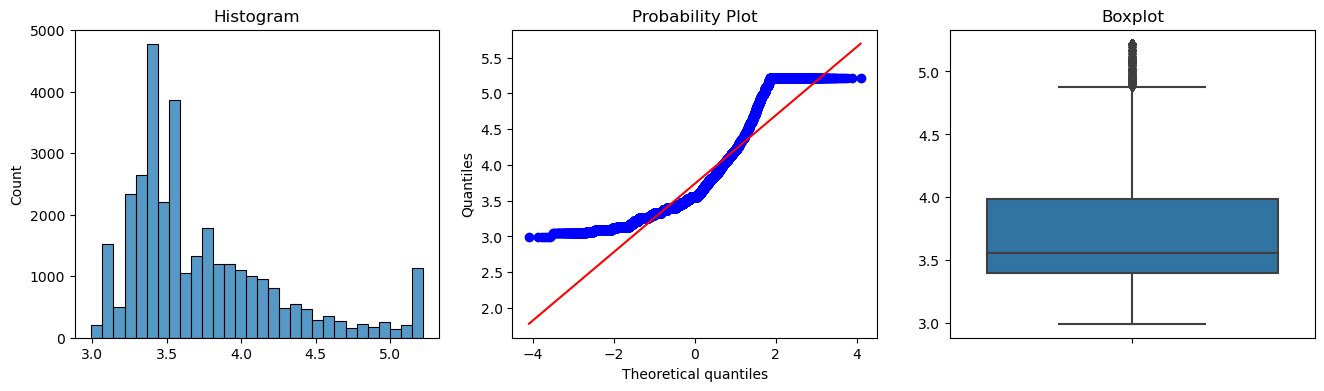

living_space:


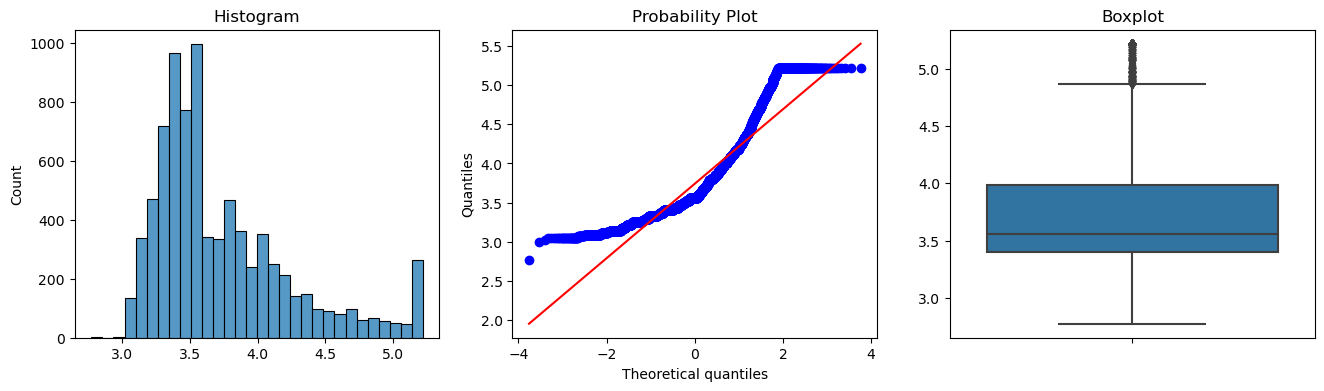

In [49]:
# test different methods of transformation
# logarithmic transformation
train_log = train_index_ohe.withColumn('living_space', log(col('living_space')))
test_log = test_index_ohe.withColumn('living_space', log(col('living_space')))

# Display transformation
diagnostic_plots(train_log,'living_space')
diagnostic_plots(test_log,'living_space')

living_space:


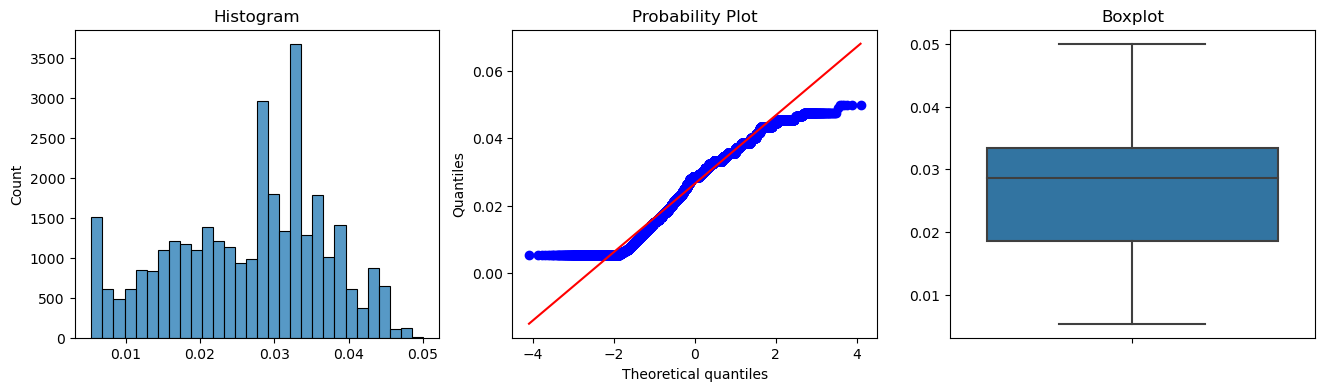

living_space:


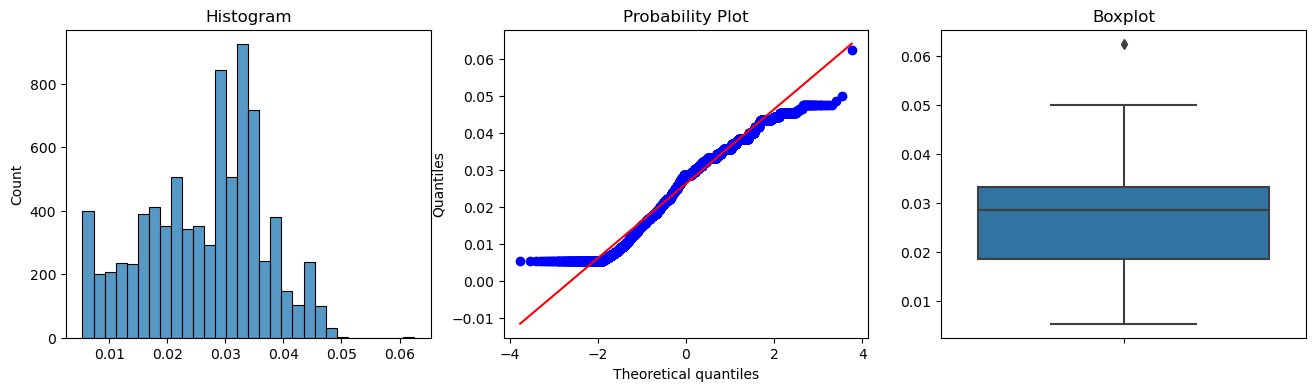

In [50]:
# reciprocal transformation
train_rec = train_index_ohe.withColumn('living_space', 1 / col('living_space'))
test_rec = test_index_ohe.withColumn('living_space', 1 / col('living_space'))

# Display transformation
diagnostic_plots(train_rec,'living_space')
diagnostic_plots(test_rec,'living_space')

living_space:


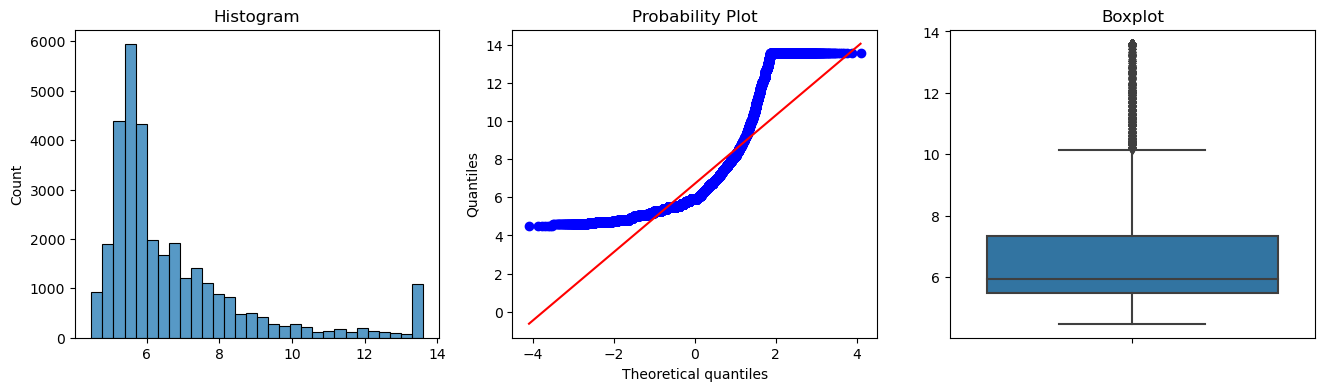

living_space:


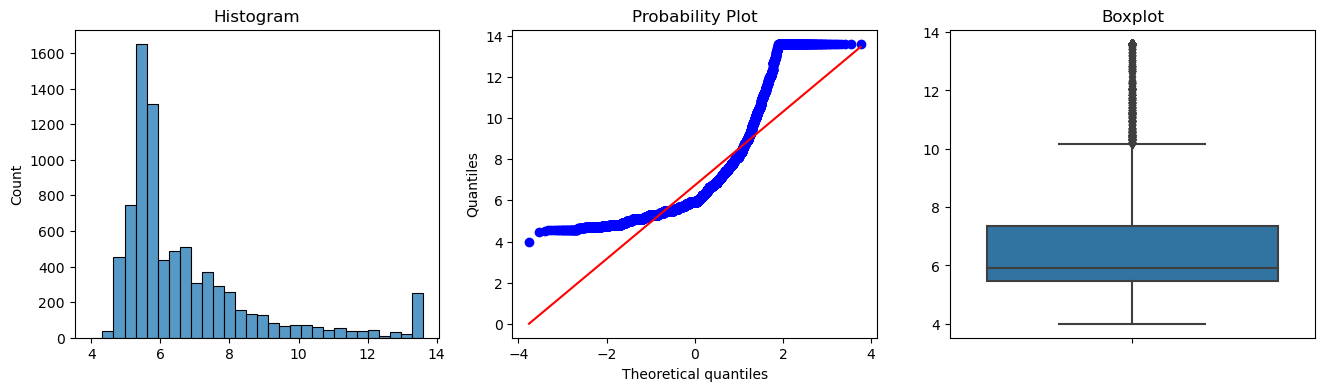

In [51]:
# square root transformation
train_sqrt = train_index_ohe.withColumn('living_space', sqrt(col('living_space')))
test_sqrt = test_index_ohe.withColumn('living_space', sqrt(col('living_space')))

# Display transformation
diagnostic_plots(train_sqrt,'living_space')
diagnostic_plots(test_sqrt,'living_space')

living_space:


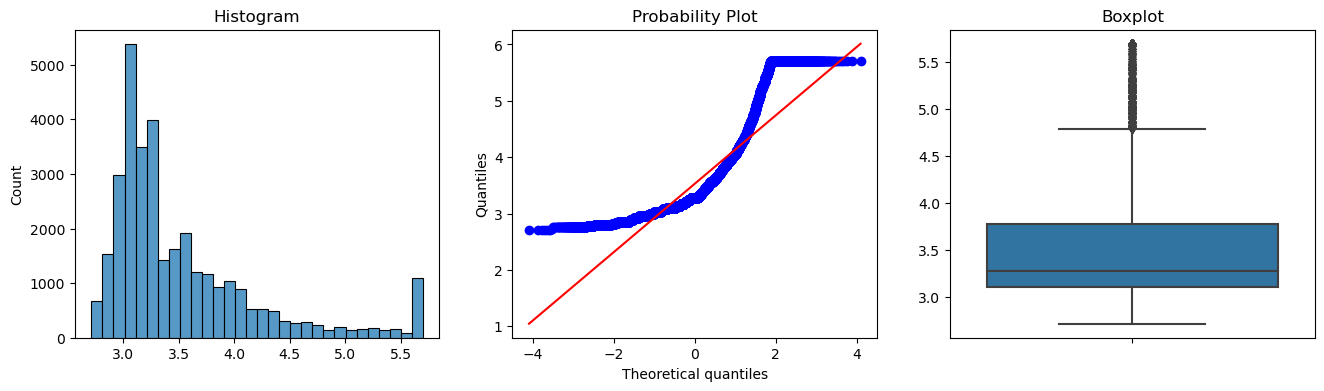

living_space:


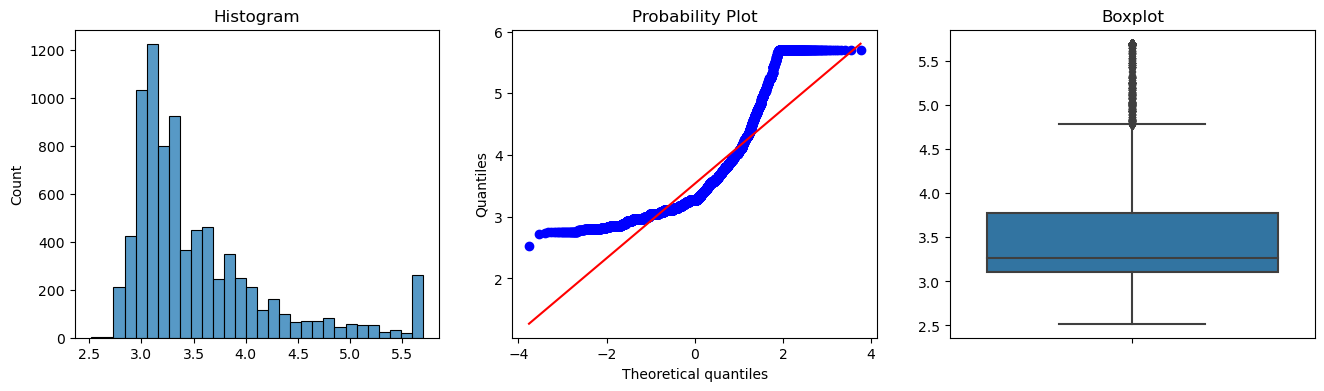

In [52]:
# cube root transformation
train_crt = train_index_ohe.withColumn('living_space', pow(col('living_space'), 1/3))
test_crt = test_index_ohe.withColumn('living_space', pow(col('living_space'), 1/3))

# Display transformation
diagnostic_plots(train_crt,'living_space')
diagnostic_plots(test_crt,'living_space')

living_space:


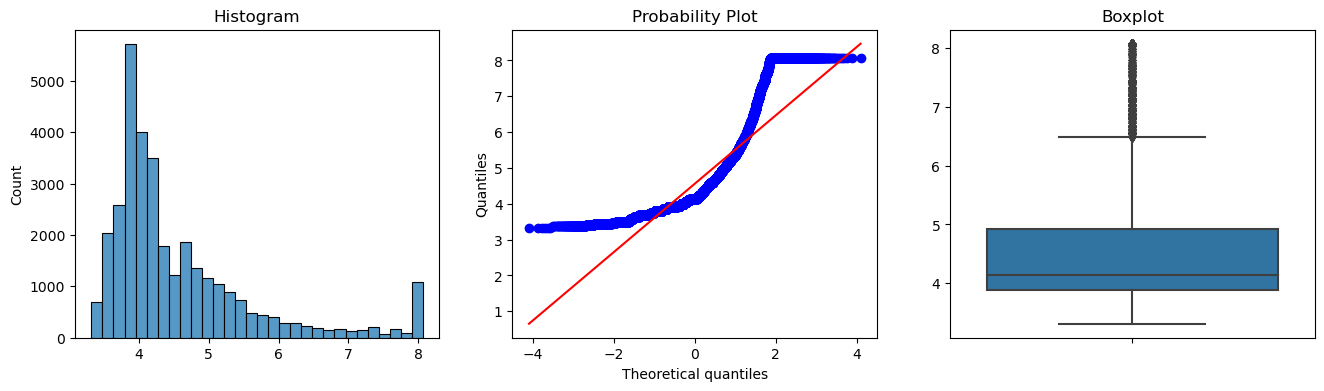

living_space:


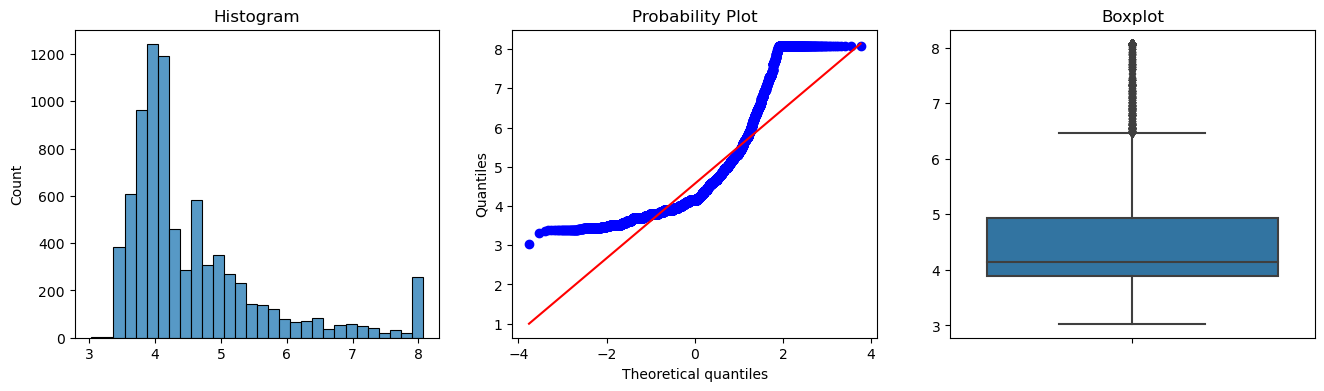

In [53]:
# power transformation
train_pow = train_index_ohe.withColumn('living_space', pow(col('living_space'), 0.4))
test_pow = test_index_ohe.withColumn('living_space', pow(col('living_space'), 0.4))

# Display transformation
diagnostic_plots(train_pow,'living_space')
diagnostic_plots(test_pow,'living_space')

living_space:


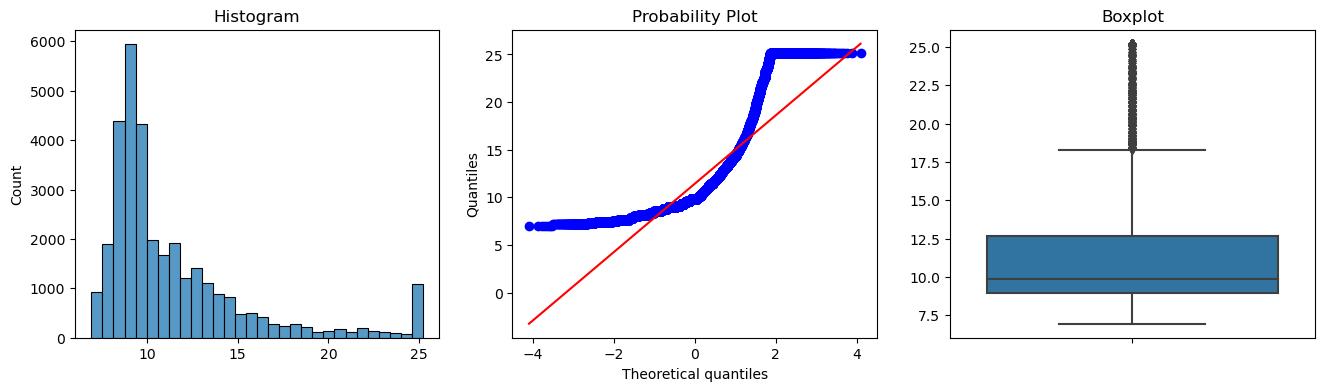

living_space:


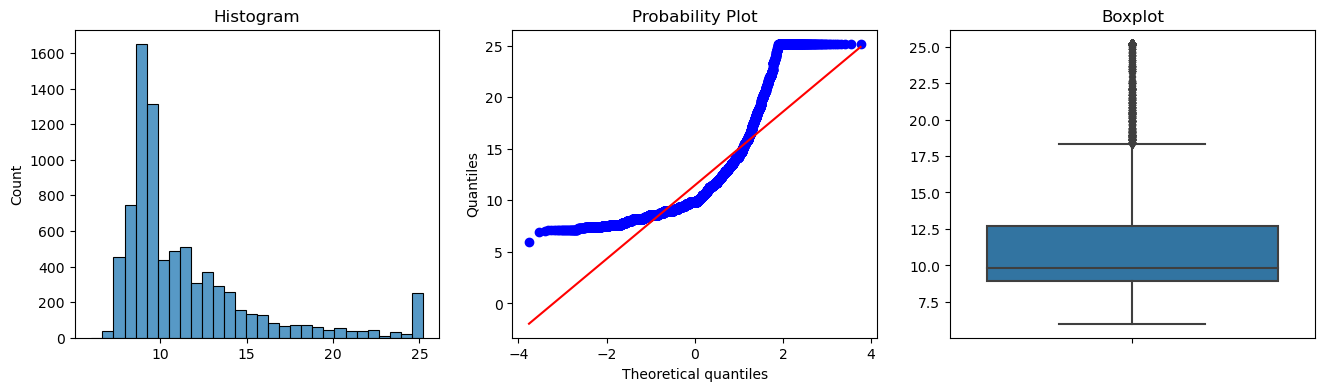

In [54]:
# box-cox transformation
train_bc = train_index_ohe.withColumn('living_space', when(col('living_space') > 0, (pow(col('living_space'), 0.5) - 1) / 0.5)
                                      .otherwise(log(col('living_space'))))
test_bc = test_index_ohe.withColumn('living_space', when(col('living_space') > 0, (pow(col('living_space'), 0.5) - 1) / 0.5)
                                      .otherwise(log(col('living_space'))))

# Display transformation
diagnostic_plots(train_bc,'living_space')
diagnostic_plots(test_bc,'living_space')

living_space:


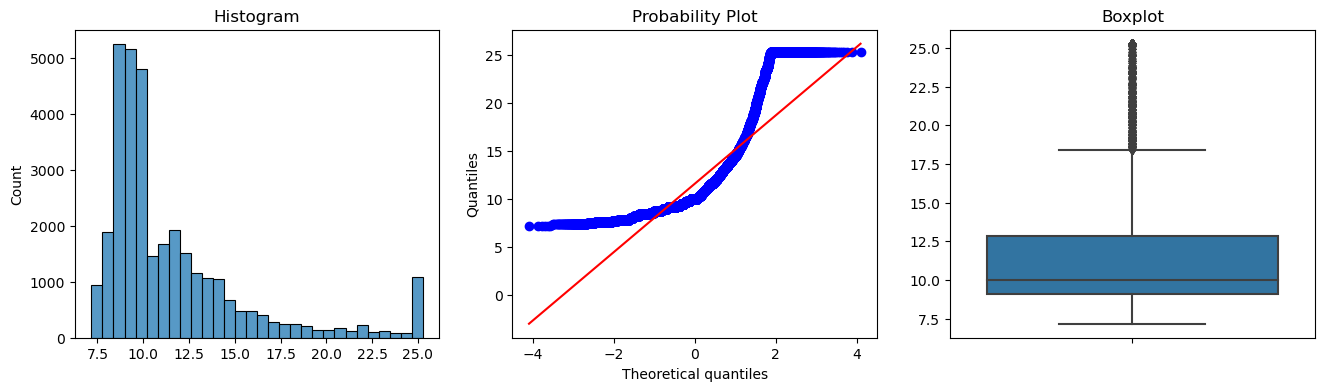

living_space:


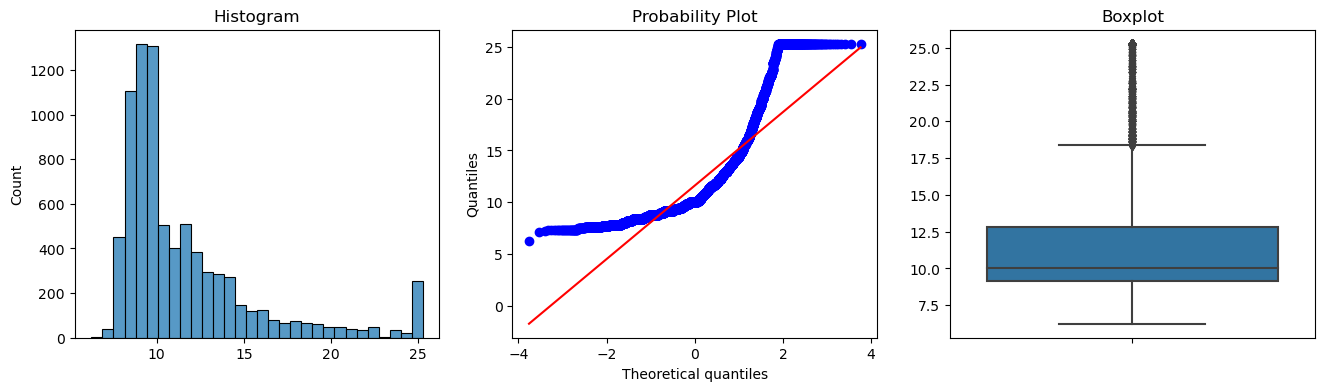

In [55]:
# yeo-johnson transformation
# Create function
def yeo_johnson_transform(value, lambda_value):
    if lambda_value == 0:  # Handle log transformation separately for lambda = 0
        return log1p(value)
    elif value >= 0:
        return ((value + 1) ** lambda_value - 1) / lambda_value
    else:
        return -(((abs(value) + 1) ** lambda_value - 1) / lambda_value)

# Define the Yeo-Johnson transformation UDF
yeo_johnson_udf = udf(lambda x: yeo_johnson_transform(x, 0.5), DoubleType())

train_yj = train_index_ohe.withColumn('living_space', yeo_johnson_udf(col('living_space')))
test_yj = test_index_ohe.withColumn('living_space', yeo_johnson_udf(col('living_space')))

# Display transformation
diagnostic_plots(train_yj,'living_space')
diagnostic_plots(test_yj,'living_space')

### 3.4 Feature Scaling<a id="part3.4"></a>
[Go to Report](#part6)

In [56]:
# Drop categorical columns
train_new = train_rec.drop('sub_property_type', 'property_type', 'city', 'state', 'listing_label', 'tenure', 'address')
test_new = test_rec.drop('sub_property_type', 'property_type', 'city', 'state', 'listing_label', 'tenure', 'address')
train_new

living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price,sub_property_type_string_encoded,property_type_string_encoded,city_string_encoded,state_string_encoded,listing_label_string_encoded,tenure_string_encoded,sub_property_type_one_hot,property_type_one_hot,city_one_hot,state_one_hot,listing_label_one_hot,tenure_one_hot
0.05,1,23,2013,13.825072,0,2,100.53759,3450000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.05,1,7,2021,13.80287539,0,1,100.5699943,2500000.0,0.0,0.0,2.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[2],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.05,1,20,2016,13.71397143,0,1,100.4718368,2000000.0,0.0,0.0,14.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[14],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,4,2016,13.733237,0,0,100.526269,4840000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,6,2016,13.733237,0,0,100.526269,4890000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,23,2016,13.733237,0,0,100.526269,4390000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,37,2016,13.733237,0,0,100.526269,5200000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,40,2016,13.733237,0,0,100.526269,4820000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,1,2014,13.80616955,0,1,100.5289486,1990000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])"
0.047619047619047616,1,11,2014,13.80616955,0,0,100.5289486,1590000.0,0.0,0.0,9.0,0.0,1.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[1],[1.0])","(1,[0],[1.0])"


In [57]:
# List of column names
cols = train_new.columns

# Drop target column name and numerical columns
cols.remove('price')

# Display column names to check
cols

['living_space',
 'bathroom_number',
 'floor_level',
 'built_year',
 'latitude',
 'premium',
 'bedroom_number',
 'longitude',
 'sub_property_type_string_encoded',
 'property_type_string_encoded',
 'city_string_encoded',
 'state_string_encoded',
 'listing_label_string_encoded',
 'tenure_string_encoded',
 'sub_property_type_one_hot',
 'property_type_one_hot',
 'city_one_hot',
 'state_one_hot',
 'listing_label_one_hot',
 'tenure_one_hot']

In [58]:
# Create Pipeline
# Set up VectorAssembler
feature_assembler = VectorAssembler(inputCols=cols, outputCol="Xcols")

# Set up StandardScaler
scaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

# Define the pipeline stages
pipeline_stages = [feature_assembler, scaler]

# Create the pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline to train data
pipeline_model = pipeline.fit(train_new)

# Transform train and test data using the pipeline
train_sscaled = pipeline_model.transform(train_new)
test_sscaled = pipeline_model.transform(test_new)

# Display scaled column
train_sscaled

living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price,sub_property_type_string_encoded,property_type_string_encoded,city_string_encoded,state_string_encoded,listing_label_string_encoded,tenure_string_encoded,sub_property_type_one_hot,property_type_one_hot,city_one_hot,state_one_hot,listing_label_one_hot,tenure_one_hot,Xcols,Xcols_sscaled
0.05,1,23,2013,13.825072,0,2,100.53759,3450000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.05,1,7,2021,13.80287539,0,1,100.5699943,2500000.0,0.0,0.0,2.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[2],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.05,1,20,2016,13.71397143,0,1,100.4718368,2000000.0,0.0,0.0,14.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[14],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.047619047619047616,1,4,2016,13.733237,0,0,100.526269,4840000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,6,2016,13.733237,0,0,100.526269,4890000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,23,2016,13.733237,0,0,100.526269,4390000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,37,2016,13.733237,0,0,100.526269,5200000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,40,2016,13.733237,0,0,100.526269,4820000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,1,2014,13.80616955,0,1,100.5289486,1990000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,11,2014,13.80616955,0,0,100.5289486,1590000.0,0.0,0.0,9.0,0.0,1.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[1],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...


## Step 4: Machine Learning Modelling<a id="part4"></a>

### 4.1 Overview of Final Dataset<a id="part4.1"></a>
[Go to Report](#part6)

In [59]:
# Display number of rows and columns in final train dataset
print((train_sscaled.count(), len(train_sscaled.columns)))

(33144, 23)


In [60]:
# Display number of rows and columns in final test dataset
print((test_sscaled.count(), len(test_sscaled.columns)))

(8155, 23)


In [61]:
# Sample of 10 rows in train dataset
train_sample = train_sscaled.limit(10)
train_sample

living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price,sub_property_type_string_encoded,property_type_string_encoded,city_string_encoded,state_string_encoded,listing_label_string_encoded,tenure_string_encoded,sub_property_type_one_hot,property_type_one_hot,city_one_hot,state_one_hot,listing_label_one_hot,tenure_one_hot,Xcols,Xcols_sscaled
0.05,1,23,2013,13.825072,0,2,100.53759,3450000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.05,1,7,2021,13.80287539,0,1,100.5699943,2500000.0,0.0,0.0,2.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[2],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.05,1,20,2016,13.71397143,0,1,100.4718368,2000000.0,0.0,0.0,14.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[14],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.047619047619047616,1,4,2016,13.733237,0,0,100.526269,4840000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,6,2016,13.733237,0,0,100.526269,4890000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,23,2016,13.733237,0,0,100.526269,4390000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,37,2016,13.733237,0,0,100.526269,5200000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,40,2016,13.733237,0,0,100.526269,4820000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,1,2014,13.80616955,0,1,100.5289486,1990000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,11,2014,13.80616955,0,0,100.5289486,1590000.0,0.0,0.0,9.0,0.0,1.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[1],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...


In [62]:
# Sample of 10 rows in test dataset
test_sample = test_sscaled.limit(10)
test_sample

living_space,bathroom_number,floor_level,built_year,latitude,premium,bedroom_number,longitude,price,sub_property_type_string_encoded,property_type_string_encoded,city_string_encoded,state_string_encoded,listing_label_string_encoded,tenure_string_encoded,sub_property_type_one_hot,property_type_one_hot,city_one_hot,state_one_hot,listing_label_one_hot,tenure_one_hot,Xcols,Xcols_sscaled
0.05,1,38,2018,13.698429,0,1,100.604787,3900000.0,0.0,0.0,5.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[5],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.28431990804284...
0.047619047619047616,1,10,2016,13.733237,0,0,100.526269,3800000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,26,2016,13.733237,0,0,100.526269,4760000.0,0.0,0.0,18.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[18],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,12,2018,13.805998,0,0,100.53296,2090000.0,0.0,0.0,9.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[9],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...
0.047619047619047616,1,2,2011,13.788892,0,1,100.580659,1890000.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[0],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,11,2019,13.772067,0,1,100.579894,2500000.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[0],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,28,2014,13.755804,0,1,100.565882,3500000.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[0],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,10,2014,13.72019284,0,1,100.502708,2850000.0,0.0,0.0,10.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[10],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,1,2018,13.698429,0,1,100.604787,3900000.0,0.0,0.0,5.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[5],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,6,...",[2.05289699621758...
0.047619047619047616,1,2,2014,13.68428388,0,0,100.6040554,1490000.0,0.0,0.0,5.0,0.0,0.0,0.0,"(1,[0],[1.0])","(2,[0],[1.0])","(36,[5],[1.0])","(10,[0],[1.0])","(2,[0],[1.0])","(1,[0],[1.0])","(66,[0,1,2,3,4,7,...",[2.05289699621758...


In [63]:
# Create train dataframe for modeling
train_data = train_sscaled.select("Xcols_sscaled","price")
train_data.show(10)

+--------------------+---------+
|       Xcols_sscaled|    price|
+--------------------+---------+
|[2.28431990804284...|3450000.0|
|[2.28431990804284...|2500000.0|
|[2.28431990804284...|2000000.0|
|[2.05289699621758...|4840000.0|
|[2.05289699621758...|4890000.0|
|[2.05289699621758...|4390000.0|
|[2.05289699621758...|5200000.0|
|[2.05289699621758...|4820000.0|
|[2.05289699621758...|1990000.0|
|[2.05289699621758...|1590000.0|
+--------------------+---------+
only showing top 10 rows



In [64]:
# Create train dataframe for modeling
test_data = test_sscaled.select("Xcols_sscaled","price")
test_data.show(10)

+--------------------+---------+
|       Xcols_sscaled|    price|
+--------------------+---------+
|[2.28431990804284...|3900000.0|
|[2.05289699621758...|3800000.0|
|[2.05289699621758...|4760000.0|
|[2.05289699621758...|2090000.0|
|[2.05289699621758...|1890000.0|
|[2.05289699621758...|2500000.0|
|[2.05289699621758...|3500000.0|
|[2.05289699621758...|2850000.0|
|[2.05289699621758...|3900000.0|
|[2.05289699621758...|1490000.0|
+--------------------+---------+
only showing top 10 rows



### 4.2 Linear Regression<a id="part4.2"></a>
[Go to Report](#part6)

In [65]:
# Create linear regressor
linregressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='price')
linregressor=linregressor.fit(train_data)

In [66]:
# Coefficients
linregressor.coefficients

DenseVector([-1943737.4052, 1770834.7568, 473474.1797, 745599.4853, 73888.46, -15915.0399, -61820.3695, -191465.4452, -6325.2736, -522095.6281, -241681.1114, 288032.2404, -54948.4812, -18764.7585, 6325.2736, 350677.0327, 121818.7365, -308893.5577, 537181.3661, -181792.9053, 422653.3641, -283355.7829, -114638.4455, 278452.9135, -139830.7579, -184753.8265, -187264.35, 258075.5214, -129195.3075, -108433.9857, 107037.2973, -170628.6729, -26224.2701, 183772.2182, -151287.7145, 510235.5239, 58804.9735, 155108.2953, 519908.8338, -30633.7278, -47508.9666, -56995.4172, -134358.0105, 40989.7154, -78107.692, -55910.5692, -42515.9522, -23806.6089, -78111.9688, -180174.332, -46562.1512, -40302.3097, -67105.7892, 201225.9022, -330664.2987, -100124.6555, -20419.0492, -180174.332, -73541.4677, -36448.2925, -114332.7139, -104338.1059, -86831.5396, 35512.4328, -15594.9472, 18764.7585])

In [67]:
# Intercept
linregressor.intercept

5261760.982771172

### 4.3 Decision Tree Regressor<a id="part4.3"></a>
[Go to Report](#part6)

In [68]:
# Create decision tree regressor
dt = DecisionTreeRegressor(featuresCol='Xcols_sscaled', labelCol='price').setSeed(42)

In [69]:
# Train the model
dt_model = dt.fit(train_data)

# Make predictions on both train and test data
dt_train_pred = dt_model.transform(train_data)
dt_test_pred = dt_model.transform(test_data)

### 4.4 Random Forest Regressor<a id="part4.4"></a>
[Go to Report](#part6)

In [70]:
# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='Xcols_sscaled', labelCol='price').setSeed(42)

In [71]:
# Train the model
rf_model = rf.fit(train_data)

# Make predictions on both train and test data
rf_train_pred = rf_model.transform(train_data)
rf_test_pred = rf_model.transform(test_data)

## Step 5: Model Evaluation and Selection<a id="part5"></a>

### 5.1 Linear Regression Evaluation<a id="part5.1"></a>
[Go to Report](#part6)

In [72]:
train_pred_results=linregressor.evaluate(train_data)
train_pred_results.predictions.show()

+--------------------+---------+-------------------+
|       Xcols_sscaled|    price|         prediction|
+--------------------+---------+-------------------+
|[2.28431990804284...|3450000.0| -847073.4358399669|
|[2.28431990804284...|2500000.0|  730825.9420638634|
|[2.28431990804284...|2000000.0| -397009.5437107058|
|[2.05289699621758...|4840000.0| 4091248.2748870505|
|[2.05289699621758...|4890000.0|  4154740.233297536|
|[2.05289699621758...|4390000.0|  4694421.879786664|
|[2.05289699621758...|5200000.0|  5138865.588660063|
|[2.05289699621758...|4820000.0|  5234103.526275793|
|[2.05289699621758...|1990000.0| -824417.7153143929|
|[2.05289699621758...|1590000.0|  -821760.827870354|
|[2.05289699621758...|2180000.0|  49613.80392509978|
|[2.05289699621758...|2090000.0|  786485.4274091413|
|[2.05289699621758...|1990000.0|  513949.9536845172|
|[2.05289699621758...|2790000.0| 465313.89378133696|
|[2.05289699621758...|3500000.0| -291847.6310601989|
|[2.05289699621758...|1890000.0| 226803.504699

In [73]:
test_pred_results=linregressor.evaluate(test_data)
test_pred_results.predictions.show()

+--------------------+---------+-------------------+
|       Xcols_sscaled|    price|         prediction|
+--------------------+---------+-------------------+
|[2.28431990804284...|3900000.0|  1180921.785447902|
|[2.05289699621758...|3800000.0|  4281724.150118507|
|[2.05289699621758...|4760000.0|  4789659.817402391|
|[2.05289699621758...|2090000.0| 342041.71853574086|
|[2.05289699621758...|1890000.0|-1067159.8933160724|
|[2.05289699621758...|2500000.0|  698443.2410055408|
|[2.05289699621758...|3500000.0|  323381.5058745118|
|[2.05289699621758...|2850000.0| 2037860.8143105386|
|[2.05289699621758...|3900000.0|  456145.9249810213|
|[2.05289699621758...|1490000.0|-173627.76078799274|
|[2.05289699621758...|1610000.0|-173724.12396444473|
|[2.05289699621758...|1390000.0| -78486.18634871673|
|[2.05289699621758...|1400000.0|   457255.170532695|
|[2.05289699621758...|1350000.0|-14994.227938232012|
|[2.05289699621758...|2100000.0|-474240.45698630903|
|[2.05289699621758...|2490000.0| 287663.043939

In [74]:
print("Metrics on Training Data:")
print("MSE: " + str(train_pred_results.meanSquaredError))
print("MAE: " + str(train_pred_results.meanAbsoluteError))
print("R^2: " + str(train_pred_results.r2))

print("\nMetrics on Test Data:")
print("MSE: " + str(test_pred_results.meanSquaredError))
print("MAE: " + str(test_pred_results.meanAbsoluteError))
print("R^2: " + str(test_pred_results.r2))

Metrics on Training Data:
MSE: 4713566596977.804
MAE: 1498340.123038718
R^2: 0.7592420510745319

Metrics on Test Data:
MSE: 4788467849421.142
MAE: 1507891.8056053275
R^2: 0.76537705485489


### 5.2 Decision Tree Regressor Evaluation<a id="part5.2"></a>
[Go to Report](#part6)

In [75]:
# Evaluate model on training data
evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction')

# Calculate MSE, MAE, and R^2 for training data
dt_train_mse = evaluator.evaluate(dt_train_pred, {evaluator.metricName: "mse"})
dt_train_mae = evaluator.evaluate(dt_train_pred, {evaluator.metricName: "mae"})
dt_train_r2 = evaluator.evaluate(dt_train_pred, {evaluator.metricName: "r2"})

# Evaluate model on test data
dt_test_mse = evaluator.evaluate(dt_test_pred, {evaluator.metricName: "mse"})
dt_test_mae = evaluator.evaluate(dt_test_pred, {evaluator.metricName: "mae"})
dt_test_r2 = evaluator.evaluate(dt_test_pred, {evaluator.metricName: "r2"})

In [76]:
dt_train_pred.show()

+--------------------+---------+------------------+
|       Xcols_sscaled|    price|        prediction|
+--------------------+---------+------------------+
|[2.28431990804284...|3450000.0| 2652441.978287093|
|[2.28431990804284...|2500000.0| 2710492.431069959|
|[2.28431990804284...|2000000.0| 2652441.978287093|
|[2.05289699621758...|4840000.0|1800296.1642871113|
|[2.05289699621758...|4890000.0|1800296.1642871113|
|[2.05289699621758...|4390000.0| 5670821.428571428|
|[2.05289699621758...|5200000.0| 5670821.428571428|
|[2.05289699621758...|4820000.0| 5670821.428571428|
|[2.05289699621758...|1990000.0|1800296.1642871113|
|[2.05289699621758...|1590000.0| 2652441.978287093|
|[2.05289699621758...|2180000.0| 2652441.978287093|
|[2.05289699621758...|2090000.0| 3253083.230703259|
|[2.05289699621758...|1990000.0| 2652441.978287093|
|[2.05289699621758...|2790000.0| 2652441.978287093|
|[2.05289699621758...|3500000.0| 2555520.596532703|
|[2.05289699621758...|1890000.0| 2710492.431069959|
|[2.05289699

In [77]:
dt_test_pred.show()

+--------------------+---------+------------------+
|       Xcols_sscaled|    price|        prediction|
+--------------------+---------+------------------+
|[2.28431990804284...|3900000.0| 4321699.623386485|
|[2.05289699621758...|3800000.0| 5670821.428571428|
|[2.05289699621758...|4760000.0| 5670821.428571428|
|[2.05289699621758...|2090000.0| 3253083.230703259|
|[2.05289699621758...|1890000.0| 2555520.596532703|
|[2.05289699621758...|2500000.0| 4321699.623386485|
|[2.05289699621758...|3500000.0| 2652441.978287093|
|[2.05289699621758...|2850000.0| 2652441.978287093|
|[2.05289699621758...|3900000.0| 2710492.431069959|
|[2.05289699621758...|1490000.0|1800296.1642871113|
|[2.05289699621758...|1610000.0|1800296.1642871113|
|[2.05289699621758...|1390000.0|1800296.1642871113|
|[2.05289699621758...|1400000.0|1800296.1642871113|
|[2.05289699621758...|1350000.0|1800296.1642871113|
|[2.05289699621758...|2100000.0|1800296.1642871113|
|[2.05289699621758...|2490000.0| 2652441.978287093|
|[2.01356165

In [78]:
print("Metrics on Training Data:")
print(f"MSE: {dt_train_mse}")
print(f"MAE: {dt_train_mae}")
print(f"R^2: {dt_train_r2}")

print("\nMetrics on Test Data:")
print(f"MSE: {dt_test_mse}")
print(f"MAE: {dt_test_mae}")
print(f"R^2: {dt_test_r2}")

Metrics on Training Data:
MSE: 4617308867115.577
MAE: 1423745.400664383
R^2: 0.7641586706094528

Metrics on Test Data:
MSE: 4640856139400.831
MAE: 1448594.433615079
R^2: 0.7726096593605374


### 5.3 Random Forest Regressor Evaluation<a id="part5.3"></a>
[Go to Report](#part6)

In [79]:
# Evaluate model on training data
evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction')

# Calculate MSE, MAE, and R^2 for training data
rf_train_mse = evaluator.evaluate(rf_train_pred, {evaluator.metricName: "mse"})
rf_train_mae = evaluator.evaluate(rf_train_pred, {evaluator.metricName: "mae"})
rf_train_r2 = evaluator.evaluate(rf_train_pred, {evaluator.metricName: "r2"})

# Evaluate model on test data
rf_test_mse = evaluator.evaluate(rf_test_pred, {evaluator.metricName: "mse"})
rf_test_mae = evaluator.evaluate(rf_test_pred, {evaluator.metricName: "mae"})
rf_test_r2 = evaluator.evaluate(rf_test_pred, {evaluator.metricName: "r2"})

In [80]:
rf_train_pred.show()

+--------------------+---------+------------------+
|       Xcols_sscaled|    price|        prediction|
+--------------------+---------+------------------+
|[2.28431990804284...|3450000.0| 3526575.020009526|
|[2.28431990804284...|2500000.0|2955414.0950788637|
|[2.28431990804284...|2000000.0|3151531.4285260374|
|[2.05289699621758...|4840000.0|3438195.8703837767|
|[2.05289699621758...|4890000.0|3438195.8703837767|
|[2.05289699621758...|4390000.0| 4406832.025493108|
|[2.05289699621758...|5200000.0| 4752156.197169589|
|[2.05289699621758...|4820000.0| 4752156.197169589|
|[2.05289699621758...|1990000.0|2707807.7414939366|
|[2.05289699621758...|1590000.0| 3127574.551018452|
|[2.05289699621758...|2180000.0|3286653.2422823883|
|[2.05289699621758...|2090000.0| 3410545.973919271|
|[2.05289699621758...|1990000.0|3539734.7389912866|
|[2.05289699621758...|2790000.0|3539734.7389912866|
|[2.05289699621758...|3500000.0|2967874.6415219274|
|[2.05289699621758...|1890000.0|2955414.0950788637|
|[2.05289699

In [81]:
rf_test_pred.show()

+--------------------+---------+------------------+
|       Xcols_sscaled|    price|        prediction|
+--------------------+---------+------------------+
|[2.28431990804284...|3900000.0|3744934.6818560497|
|[2.05289699621758...|3800000.0| 4339996.009196753|
|[2.05289699621758...|4760000.0| 4499074.700460689|
|[2.05289699621758...|2090000.0| 3251467.282655335|
|[2.05289699621758...|1890000.0|2773354.8719101255|
|[2.05289699621758...|2500000.0|3398221.0041535185|
|[2.05289699621758...|3500000.0|3604073.9090610384|
|[2.05289699621758...|2850000.0|3157888.3503946373|
|[2.05289699621758...|3900000.0|2776920.3938193494|
|[2.05289699621758...|1490000.0|2332814.8554796306|
|[2.05289699621758...|1610000.0|2332814.8554796306|
|[2.05289699621758...|1390000.0|2332814.8554796306|
|[2.05289699621758...|1400000.0| 2383506.470537613|
|[2.05289699621758...|1350000.0|2332814.8554796306|
|[2.05289699621758...|2100000.0|2673592.8392105633|
|[2.05289699621758...|2490000.0| 3263155.081505912|
|[2.01356165

In [82]:
print("Metrics on Training Data:")
print(f"MSE: {rf_train_mse}")
print(f"MAE: {rf_train_mae}")
print(f"R^2: {rf_train_r2}")

print("\nMetrics on Test Data:")
print(f"MSE: {rf_test_mse}")
print(f"MAE: {rf_test_mae}")
print(f"R^2: {rf_test_r2}")

Metrics on Training Data:
MSE: 4647868095418.2705
MAE: 1498784.3028095732
R^2: 0.7625977767564585

Metrics on Test Data:
MSE: 4772468674993.069
MAE: 1522488.1768557902
R^2: 0.7661609743761746


### Step 6: Report<a id="part6"></a>

>### [1 Problem Formulation](#part1)
>>#### 1.1 Understanding Data & Formulating Value Based Problem Statement
>>Various factors such as location and size influence an individual's decisions to purchase a house. For instance, a family of six would normally prefer a larger house with more bedrooms, nearby schools or workplaces. These factors contribute to the price value of the property, which is also one of the key factors in deciding to purchase a house. 
>>
>>I generally explored this dataset, comprising of transactions of property in Thailand. Firstly, data such as living space, floor level, number of bathrooms and bedrooms, year built, and geographical coordinates are crucial metrics directly impacting the valuation of property. For example, larger living spaces are usually priced higher as they offer more functional space for residents. These metrics allow for a more accurate assessment of a property's worth in the real estate market. Furthermore, property type, tenure, and location specifics play pivotal roles in understanding market trends and demands, shaping the pricing landscape. Specifics like city, state, and address can determine accessibility to amenities, transportation, and schools. Integrating these attributes into the price predictive model is important as they encapsulate a great deal of aspects contributing significantly to property price variations in Thailand. 
>>
>>Building this model helps stakeholders make more informed decisions by estimating a property's value based on various attributes, facilitating in setting realistic expectations. Moreover, it simplifies property valuation processes, improving efficiency for real estate agents and buyers.

>### [2 Exploratory Data Analysis & Data Cleansing](#part2)
>>#### [2.1 Exploratory Data Analysis](#part2.1)
>>>##### [2.1.1 Univariate Analysis](#part2.1.1)
>>>Firstly, I plotted out a histogram and a boxplot to understand the distribution of prices. The visualisation shows that it is highly left-skewed, and there are many extreme values. This would be explored in depth later on when handling outliers.
>>>
>>>Secondly, I printed out the descriptive statistics of numerical variables and bar charts of the counts of each category in categorical variables. This helps me to understand which category has the highest frequency, for instance.
>>>
>>>##### [2.1.2 Bivariate Analysis](#part2.1.2)
>>>For bivariate analysis, I observed the mean price of property for each category or value in a variable, to identify any patterns. Some interesting finds are that I discovered that on average, apartments are priced about 7 times more expensive than a townhouse or condo. Besides that, houses with 2 or more bedrooms or bathrooms are priced significantly higher than houses with 1 or 0 bedrooms or bathrooms.
>>#### [2.2 Handling Missing Values](#part2.2)
>>>I discovered that 'living_space' has 50 null values, which made up only 0.12% of the total number of values. Hence, I dropped the rows with missing values, as it would not significantly affect the model.
>>#### [2.3 Determining Cardinality](#part2.3)
>>>I observed the cardinality and dropped 'property_id' as its cardinality is too high and 'currency' as it only has a cardinality of 1. These variables do not have a predictive value and are redundant, thus they are dropped.
>>#### [2.4 Handling Outliers](#part2.4)
>>>##### [2.4.1 Handling Outliers in 'price'](#part2.4.1)
>>>From the diagnostic plots, descriptive statistics and observing of rows, I found that there were property priced at 0, and the highest-priced property costed more than twice the second highest-priced property. Since there were many extreme values, and the value at the 75th percentile was only 6,300,000, I winsorised both ends by 0.05. 
>>>
>>>##### [2.4.2 Handling Outliers in 'living_space'](#part2.4.2)
>>>I discovered that there were extreme values in 'living_space', such as 989,898. Assuming that the unit of measurement is in square metres, a condo of 989,898sqm with only 2 bathrooms and 3 bedrooms seems like an error. Since there were many extreme values, and the value at the 75th percentile was only 53, I winsorised the right end by 0.02 to still maintain variability, but handle extreme outliers. 
>>>
>>>##### [2.4.3 Handling Outliers in 'floor_level'](#part2.4.3)
>>>After observing the outlier values, I discovered that there are values as high as 628,266,569. This is even taller than the tallest building in the world, which only has 163 stories. I also researched on buildings with the highest number of storeys in Thailand, which showed that the highest number is 85. Thus, I capped the values at 85.
>>> 
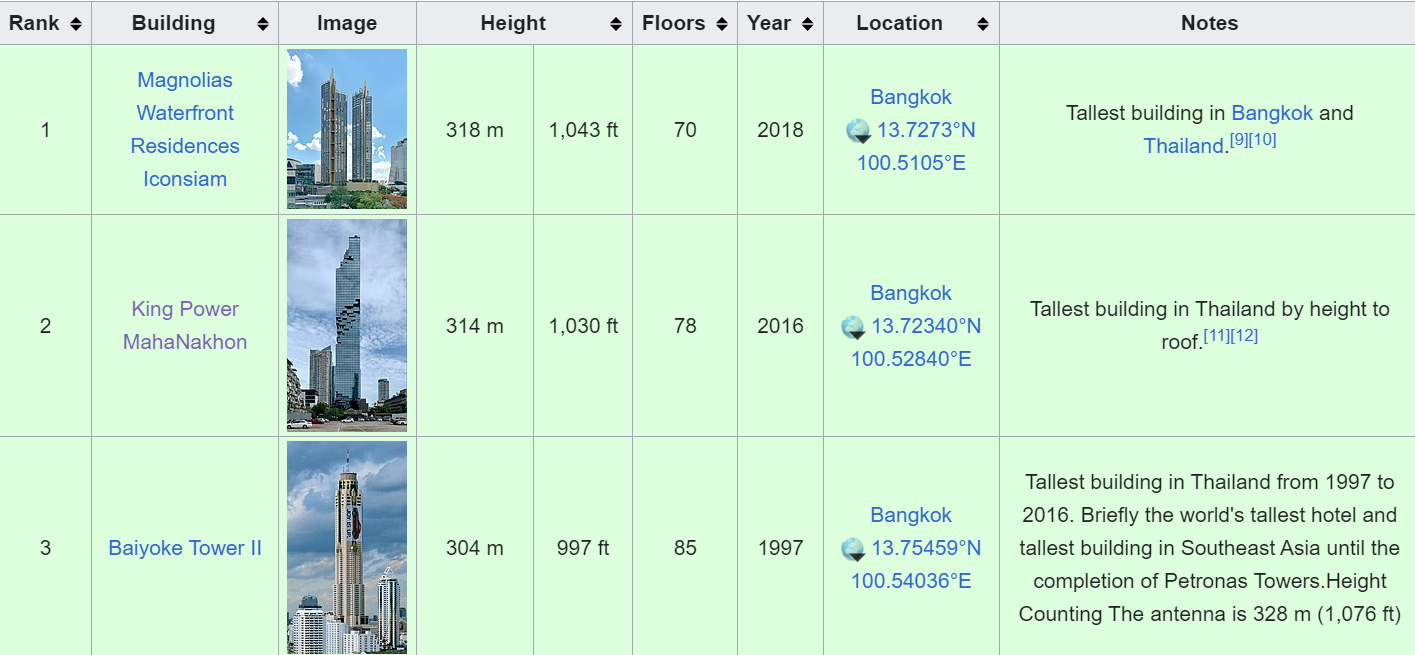
>>>##### [2.4.4 Handling Outliers in 'bedroom_number'](#part2.4.4)
>>>I observed the other condo houses at the condominium of the condo house with 11 bedrooms. The other condos only have 1 or 2 bedrooms. Condos with 2 bedrooms have a living space range of about 50 to 70sqm, while condos with 1 bedroom have a lower range of 29 to 35sqm. Thus, since the outlier condo has a living space of 29sqm, I replaced the 'bedroom_number' value of 11 with 1.
>>#### [2.5 Handling Rare Categories](#part2.5)
>>>##### [2.5.1 Dropping Rare Categories](#part2.5.1)
>>>'property_type' and 'tenure' contains categories which appear 4 and 7 times respectively. Since there is a chance that these categories appear in the test but not the train set, which would result in a problem when encoding, I dropped these categories.
>>>
>>>##### [2.5.2 Regrouping Rare Categories](#part2.5.2)
>>>By observing the bar charts, regrouping categories below 0.5% frequency level in 'state' as 'Other' would result in having vary few categories left, thus I retained the top 10 categories with the highest frequency and regrouped the rest as 'Other' to still maintain variability. For 'city', I regrouped categories below 0.5% frequency level as 'Other'.

>### [3 Data Wrangling & Transformation](#part3)
>>#### [3.1 Train Test Split](#part3.1)
>>>Before moving on, I split my dataset into 80% for training and 20% for testing and checked the categories of each categorical variable in train and test to check if there are any categories that appeared in test but not in train. I decided to split into 80% and 20% as using a larger portion for training allows the model to learn patterns and relationships present in the data adequately and allows for more robust learning. 
>>#### [3.2 Categorical Encoding](#part3.2)
>>> Since there is no hierarchy or order present in each of the categorical variables, I performed one-hot encoding for all the categorical variabes instead of ordinal encoding. I created a pipeline to perform string indexing followed by one-hot encoding. Using StringIndexer before one-hot encoding ensures that categorical variables are appropriately preprocessed and transformed into a format that machine learning algorithms can handle effectively.
>>#### [3.3 Numerical Transformation](#part3.3)
>>>To identify the best method of transformation, I tried out 7 different methods of transformation which are:
>>>- Logarithmic Transformation
>>>- Reciprocal Transformation
>>>- Square Root Transformation
>>>- Cube Root Transformation
>>>- Power Transformation
>>>- Box-Cox Transformation
>>>- Yeo-Johnson Transformation
>>>After observing the effect of each transformation on 'living_space', Reciprocal Transformation handled most of the outliers and aligned more data points with the straight line in the probability plot. This alignment suggests that the data distribution closely resembles a typical normal distribution, which enhances the reliability and accuracy of the model. Furthermore, the distribution is more normalised than before.
>>#### [3.4 Feature Scaling](#part3.4)
>>>I dropped the categorical columns before proceeding. I used vectorization to gather the numerical columns and encoded categorical columns to increase efficiency for standardization. Standardization helps to rescale variables to have a mean of 0 and variance of 1. I performed standardization as the variables have very different scales, for instance, longitude and bedroom_number. I created a pipeline to carry out vectorization, followed by standardization on the new column created by vectorization.

>### [4 Machine Learning Modelling](#part4)
>>#### [4.1 Overview of Final Dataset](#part4.1)
>>>The final train set contains 33144 rows and 23 columns, while the final test set contains 8155 rows and 23 columns. I also displayed a sample of 10 rows in the final train and test set each.
>>#### [4.2 Linear Regression](#part4.2)
>>>Linear regression aims to predict the value of a dependent variable -- 'price', based on the values of one or more independent variables. The model assumes a linear relationship between the variables and 'price'.
>>#### [4.3 Decision Tree Regressor](#part4.3)
>>>Decision tree regressor creates a tree that predicts the continuous target variable by learning simple decision rules inferred from the features. The algorithm aims to split the data to minimize the variance of the target variable within each resulting subset. It is able to capture nonlinear relationships in the data.
>>#### [4.4 Random Forest Regressor](#part4.4)
>>>Random forest regressor is an extension of the decision tree algorithm and combines multiple individual decision trees to make predictions. After training multiple decision trees, predictions from each tree are aggregated by taking the mean, for example, to make the final prediction. It can also capture nonlinear relationships effectively.

>### [5 Model Evaluation & Selection](#part5)
>The models built can be evaluated by observing the predictions made by the model and by using various metrics such as mean squared error (MSE), mean absolute error (MAE), coefficient of determination (R-squared). 
>>#### [5.1 Linear Regression Evaluation](#part5.1)
>>>The model had predicted negative values and some predictions were very far off from the actual price. The metrics suggest that there is a minor increase in prediction errors on the test set as it has a slightly higher MSE and MAE, but overall, the model performs reasonably well, showing similar performance on both training and test data.
>>>>Metrics on Training Data:                   
>>>>- MSE: 4713566596977.804
>>>>- MAE: 1498340.123038718
>>>>- R^2: 0.7592420510745319
>>>>
>>>>Metrics on Test Data:
>>>>- MSE: 4788467849421.142
>>>>- MAE: 1507891.8056053275
>>>>- R^2: 0.76537705485489
>>#### [5.2 Decision Tree Regressor Evaluation](#part5.2)
>>>The model predicted values that were not as far off from the actual price. The metrics suggest that the model performs consistently on both training and test datasets, suggesting good generalization ability without significant differences in performance between the two datasets.
>>>>Metrics on Training Data:
>>>>- MSE: 4617308867115.577
>>>>- MAE: 1423745.400664383
>>>>- R^2: 0.7641586706094528
>>>>
>>>>Metrics on Test Data:
>>>>- MSE: 4640856139400.831
>>>>- MAE: 1448594.433615079
>>>>- R^2: 0.7726096593605374
>>#### [5.3 Random Forest Regressor Evaluation](#part5.3)
>>>The model predicted values that were also not as far off from the actual price. Overall, the metrics suggest that the model exhibits good generalization properties, with consistent performance on both training and test datasets, suggesting a reliable model fit.
>>>>Metrics on Training Data:
>>>>- MSE: 4647868095418.2705
>>>>- MAE: 1498784.3028095732
>>>>- R^2: 0.7625977767564585
>>>>
>>>>Metrics on Test Data:
>>>>- MSE: 4772468674993.069
>>>>- MAE: 1522488.1768557902
>>>>- R^2: 0.7661609743761746

>From the observations above, Decision Tree Regressor model was the best out of the three as its train and test's MSE and MAE values are generally lower and R^2 is higher than the other two models. This suggests that it explains the highest variance in both datasets and its predictions are closer to the actual values. Besides that, since the metrics between the training and test data were very close, it indicates that the model performance was consistent across both datasets. Furthermore, the model did not predict negative values like the Linear Regression model.

>### 6 Summary and Further Improvements
>>#### 6.1 Summary
>>>This dataset on Thailand's property transactions brought about many interesting observations, such as anomalies and errors which made up some of the extreme outliers. For instance, a property had almost 3.9 million times more stories than the tallest building in the world. Using Pyspark, this dataset was cleaned by handling its outliers, missing values and rare categories. Afterwards, to enhance interpretability and model performance, the categorical variables were one-hot encoded and 'living_space' underwent Reciprocal Transformation, which was the best out of the seven transformations tested. Before building the price predictive models, the variables were vectorised and scaled to further improve interpretability. Three different models were built, and out of the three, the Decision Tree Regressor model produced the best results.
>>#### 6.2 Further Improvements
>>>Firstly, I could have explored different ways of handling outliers for each variable, such as performing both winzorisation and capping on a variable to observe its effect on the model performance. I could have also explored inputting different values such as for numerical transformations like Power and Yeo-Johnson. Furthermore, I could have tried performing feature engineering techniques such as Polynomial Expansion and Principal Component Analysis.

[Back to Top](#top)